# Спортивный анализ данных. Платформа Kaggle

## Урок 2. Обзор основных алгоритмов машинного обучения, используемых в соревнованиях

### Домашнее задание:

В домашнем задании, будем обучать разные алгоритмы машинного обучения. Для этого, нужно предварительно зафиксировать схему валидации решения (можете выбрать любую, которую знаете). Выбранную схему валидации нужно использовать во всех задачах этого домашнего задания. Метрика качества - **ROC AUC**, целевая переменная - **isFraud**.

Ссылка на данные - https://drive.google.com/file/d/1gMEVl47pIoV1-AseB9doQ6DZNJrY3NkW/view?usp=sharing

**[Задание 1](#task1):** отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

**[Задание 2](#task2):** обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

**[Задание 4](#task4):** для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

**[Задание 5](#task5):** обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

**[Задание 6](#task6):** обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

**[Задание 7](#task7):** для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

**[Задание 8](#task8):** обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

**[Задание 9](#task9):** обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

**[Задание 10](#task10):** построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

**Задание на повторение:**

Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных, этот набор данных будет использован и для следующего домашнего задания.

**[Задание 1](#task_1):** Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

**[Задание 2](#task_2):** построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и 
для переменной = 1. Сделать выводы.

**[Задание 3](#task_3):** построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

**[Задание 4](#task_4):** построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

## Подключение библиотек и скриптов

In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd 
# разварачиваем выходной дисплей, чтобы увидеть больше столбцов и строк a pandas DataFrame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#pd.options.display.max_info_columns = 400
#pd.options.display.max_columns = 300

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

import missingno as msno  # Missingo предлагает быстрый и простой способ по визуализации отсутствующих значений.

import xgboost as xgb

%matplotlib inline

In [2]:
#Нарисовать граф с Graphviz в Jupyter Notebook
#http://diginal.ru/python/narisovat-graf-s-graphviz-v-jupyter-notebook/
import sys
sys.path #можно посмотреть что в PATH
#graphviz_path = '...\\Anaconda3\\Library\\bin\\graphviz'  #не забыть поправить ... и поставить двойные юниксовые слеши
graphviz_path = 'C:\\ProgramData\\Anaconda3\\Library\\bin\\graphviz'

sys.path.insert(0, graphviz_path)
#sys.path.remove(graphviz_path) - если что-то пошло не так и путь нужно удалить
!dot -V  #проверить, что всё работает - должен вывести версию graphviz

dot - graphviz version 2.38.0 (20140413.2041)


In [3]:
def reduce_mem_usage(df):
    '''Сокращение размера датафрейма за счёт изменения типа данных'''
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Пути к директориям и файлам**

In [4]:
# input
TRAIN_DATASET_PATH = './data/assignment_2_train.csv'
TEST_DATASET_PATH = './data/assignment_2_test.csv'

# output
#PREP_DATASET_PATH = './assignment1_data/data_prep.csv'

## Загрузка данных

In [5]:
# Тренировочные данные
# train = pd.read_csv(TRAIN_DATASET_PATH, header = none)  # если надо скрыть названия столбцов
train = pd.read_csv(TRAIN_DATASET_PATH)
df_train =reduce_mem_usage(train)  # Уменьшаем размер данных
# Тестовые данные
test = pd.read_csv(TEST_DATASET_PATH)
df_test =reduce_mem_usage(test)  # Уменьшаем размер данных

Memory usage of dataframe is 541.08 MB
Memory usage after optimization is: 262.48 MB
Decreased by 51.5%
Memory usage of dataframe is 300.60 MB
Memory usage after optimization is: 145.83 MB
Decreased by 51.5%


**Размерности датасетов**

In [6]:
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 180000 rows, 394 cols
test.shape = 100001 rows, 394 cols


**Числовые признаки**

In [7]:
numerical_features = train.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32']).columns
print(numerical_features)

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339'], dtype='object', length=380)


**Категориальные признаки**

In [8]:
#categorical_features = train.select_dtypes(include=[np.object])
categorical_features = train.select_dtypes(include=['category'])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head(n=2)

Categorical Feature Count 14


ProductCD       card4   card6 P_emaildomain R_emaildomain   M1   M2   M3  M4 M5 M6   M7   M8   M9
0         W    discover  credit           NaN           NaN    T    T    T  M2  F  T  NaN  NaN  NaN
1         W  mastercard  credit     gmail.com           NaN  NaN  NaN  NaN  M0  T  T  NaN  NaN  NaN

In [9]:
#df_train.select_dtypes(include='object').columns
df_train.select_dtypes(include='category').columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'], dtype='object')

## Тренировочный датасет

### Обзор целевой переменной

In [10]:
target = 'isFraud'
df_train[target].value_counts()  # Количество различных значений признака 'Credit Default'

0    174859
1      5141
Name: isFraud, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


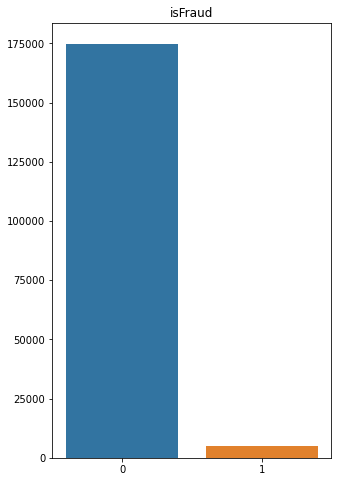

In [11]:
counts = df_train[target].value_counts()
    
plt.figure(figsize=(5,8))    
plt.title(target)
sns.barplot(counts.index, counts.values)
    
plt.show()

In [12]:
#pd.options.display.max_info_columns = 400
#pd.options.display.max_columns = 400

In [13]:
train.info()
# Идея 1. Рассматривать только те параметры у которых кол-во непустых значений > 100000 (50000).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 394 entries, TransactionID to V339
dtypes: category(14), float32(376), int16(1), int32(2), int8(1)
memory usage: 262.5 MB


In [14]:
#train.dtypes

In [15]:
train.head()
# 86400 - 1 day, 0:00:00
#train.tail()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2 P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9   D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8   M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  V95   V96   V97  V98   V99  V100  V101  V102  V103  V104  V105  V106  V107  V108  V109  V110  V111  V112  V113  V114  V115  V116  V117  V118  V119  V120  \
0        2987000        0          86400            68.5         W  13926    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   1.0   0.0  0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1        2987001        0          86401            29.0         W   2755  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2        2987002        0          86469            59.0         W   4663  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3        2987003   

## Тестовый датасет

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Columns: 394 entries, TransactionID to V339
dtypes: category(14), float32(376), int16(1), int32(2), int8(1)
memory usage: 145.8 MB


In [17]:
#test.dtypes

In [18]:
test.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  card3 card4  card5   card6  addr1  addr2  dist1  dist2  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14   D1   D2   D3   D4   D5  D6  D7  D8  D9    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5 M6   M7   M8   M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  V95  V96  V97  V98  V99  V100  V101  V102  V103  V104  V105  V106  V107  V108  V109  V110  V111  V112  V113  V114  V115  V116  V117  V118  V119  V120  V121  V122  V123  \
0        3287000        1        7415038      226.000000         W  12473  555.0  150.0  visa  226.0  credit  299.0   87.0  116.0    NaN        aol.com           NaN  2.0  3.0  0.0  0.0  0.0  5.0  0.0  0.0  3.0  0.0  3.0  2.0   6.0  2.0  4.0  4.0  0.0  4.0  3.0 NaN NaN NaN NaN    4.0    4.0  NaN  NaN  NaN    3.0    T    T    F   M0    T  F    F    F    T  1.0  2.0  2.0  1.0  3.0  1.0  1.0  1.0  2.0  0.0  0.0  2.0  2.0  1.0  0.0  0.0  0.0  0.0  2.0  5.0  0.0  0.0  1.0  1.0  1.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  2.0  2.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  2.0  0.0  0.0  0.0  1.0  1.0  2.0  2.0  2.0  2.0  0.0  0.0  0.0  0.0  2.0  5.0  0.0  0.0  1.0  1.0  2.0  0.0  0.0  0.0  0.0  0.0  1.0  2.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  3.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  7.0  7.0  0.0  1.0   1.0   2.0   6.0   6.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1        3287001        0        7415054     3072.000000         W  15651  417.0  150.0  visa  226.0   debit  330.0   87.0    NaN    NaN      yahoo.com           NaN  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0  0.0  NaN  0.0  0.0  0.0 NaN NaN NaN NaN    0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN  NaN  NaN  T  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2        3287002        0        7415081      319.950012         W  13844  583.0  150.0  visa  226.0  credit  126.0   87.0    9.0    NaN      gmail.com           NaN  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0  0.0  NaN  0.0  0.0  0.0 NaN NaN NaN NaN    0.0    0.0  NaN  NaN  NaN    0.0    T    T    T  NaN  NaN  T    F    F    T  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3      

## Базовые статистики

In [19]:
# Тренировочный датасет
train.describe().T

count          mean           std          min           25%           50%           75%           max
TransactionID   180000.0  3.077000e+06  5.196167e+04  2987000.000  3.032000e+06  3.077000e+06  3.121999e+06  3.166999e+06
isFraud         180000.0  2.856111e-02  1.665699e-01        0.000  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00
TransactionDT   180000.0  1.909818e+06  1.039029e+06    86400.000  1.091681e+06  1.884075e+06  2.693196e+06  3.958317e+06
TransactionAmt  180000.0  1.294917e+02  2.065206e+02        0.292  4.400000e+01  7.500000e+01  1.250000e+02  5.278950e+03
card1           180000.0  9.860226e+03  4.910778e+03     1001.000  6.019000e+03  9.633000e+03  1.418200e+04  1.839600e+04
card2           177389.0  3.683454e+02  1.589787e+02      100.000  2.150000e+02  3.750000e+02  5.140000e+02  6.000000e+02
card3           179997.0  1.534064e+02  1.153677e+01      100.000  1.500000e+02  1.500000e+02  1.500000e+02  2.310000e+02
card5           179047.0  2.003184e+02  4.058468e+01      100.000  1.660000e+02  2.260000e+02  2.260000e+02  2.370000e+02
addr1           160567.0  2.911745e+02  1.022446e+02      100.000  2.040000e+02  2.990000e+02  3.300000e+02  5.400000e+02
addr2           160567.0  8.655991e+01  3.963716e+00       10.000  8.700000e+01  8.700000e+01  8.700000e+01  1.020000e+02
dist1            60605.0  1.262432e+02  3.862911e+02        0.000  3.000000e+00  9.000000e+00  2.600000e+01  7.068000e+03
dist2            14458.0  2.409624e+02  5.478262e+02        0.000  7.000000e+00  2.700000e+01  2.180000e+02  9.103000e+03
C1              180000.0  2.577743e+01  2.320075e+02        0.000  1.000000e+00  1.000000e+00  2.000000e+00  4.685000e+03
C2              180000.0  2.935002e+01  2.698468e+02        0.000  1.000000e+00  1.000000e+00  2.000000e+00  5.691000e+03
C3              180000.0  8.550000e-03  1.496975e-01        0.000  0.000000e+00  0.000000e+00  0.000000e+00  1.700000e+01
C4              180000.0  1.085560e+01  1.172766e+02        0.000  0.000000e+00  0.000000e+00  1.000000e+00  2.253000e+03
C5              180000.0  4.477589e+00  2.263327e+01        0.000  0.000000e+00  0.000000e+00  1.000000e+00  3.490000e+02
C6              180000.0  1.509729e+01  1.190502e+02        0.000  1.000000e+00  1.000000e+00  2.000000e+00  2.253000e+03
C7              180000.0  8.683145e+00  1.112780e+02        0.000  0.000000e+00  0.000000e+00  0.000000e+00  2.255000e+03
C8              180000.0  1.458953e+01  1.704899e+02        0.000  0.000000e+00  0.000000e+00  1.000000e+00  3.331000e+03
C9              180000.0  3.569739e+00  1.504422e+01        0.000  0.000000e+00  1.000000e+00  1.000000e+00  2.070000e+02
C10             180000.0  1.490817e+01  1.710293e+02        0.000  0.000000e+00  0.000000e+00  1.000000e+00  3.257000e+03
C11             180000.0  1.867824e+01  1.625639e+02        0.000  1.000000e+00  1.000000e+00  2.000000e+00  3.188000e+03
C12             180000.0  1.217315e+01  1.561579e+02        0.000  0.000000e+00  0.000000e+00  0.000000e+00  3.188000e+03
C13             180000.0  3.622705e+01  1.747013e+02        0.000  1.000000e+00  2.000000e+00  9.000000e+00  2.918000e+03
C14             180000.0  1.186061e+01  7.862904e+01        0.000  1.000000e+00  1.000000e+00  2.000000e+00  1.429000e+03
D1              180000.0  7.743692e+01  1.395878e+02        0.000  0.000000e+00  0.000000e+00  8.700000e+01  6.390000e+02
D2               80302.0  1.643483e+02  1.636732e+02        0.000  2.500000e+01  1.000000e+02  2.800000e+02  6.390000e+02
D3               83038.0  2.897034e+01  6.167242e+01        0.000  1.000000e+00  8.000000e+00  2.700000e+01  6.740000e+02
D4              106927.0  1.270491e+02  1.722500e+02     -122.000  0.000000e+00  1.700000e+01  2.420000e+02  7.350000e+02
D5               68756.0  4.147814e+01  8.384343e+01        0.000  1.000000e+00  9.000000e+00  3.200000e+01  7.310000e+02
D6               24236.0  5.801118e+01  1.301207e+02      -83.000  0.000000e+00  0.000000e+00  9.000000e+00  7.3800

In [20]:
# Тестовый датасет
# test.describe().T

**Создаём набор числовых признаков**

In [21]:
numerical_features = train.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32']).columns

In [22]:
# Общее количество записей в датафрейме = 180 000
# Исключаем такие поля содержащие меньше 100 000 значений,
# из предполажения, что значение этих полей несущественно (всегда можно этот параметр проварьировать).
 
numerical_features_1 = [
#'TransactionID',  # Индекс
#'isFraud',  # Целевой параметр
'TransactionDT',  # Временя совершения транзакции
'TransactionAmt',  # Сумма транзакции
'card1',
'card2',
'card3',
'card5',
'addr1',
'addr2',
#'dist1', ## < 100 000
#'dist2', ## <  50 000
'C1',
'C2',
'C3',
'C4',
'C5',
'C6',
'C7',
'C8',
'C9',
'C10',
'C11',
'C12',
'C13',
'C14',
'D1',
#'D2', ## < 100 000
#'D3', ## < 100 000
'D4',
#'D5', ## < 100 000
#'D6', ## <  50 000
#'D7', ## <  50 000
#'D8', ## <  50 000
#'D9', ## <  50 000
'D10',
'D11', ## <  50 000
#'D12', ## <  50 000
#'D13', ## <  50 000
#'D14', ## <  50 000
'D15']
#
numerical_features_2 = [
#'V1', ## < 100 000
#'V2', ## < 100 000
#'V3', ## < 100 000
#'V4', ## < 100 000
#'V5', ## < 100 000
#'V6', ## < 100 000
#'V7', ## < 100 000
#'V8', ## < 100 000
#'V9', ## < 100 000
#'V10', ## < 100 000
#'V11', ## < 100 000
'V12',
'V13',
'V14',
'V15',
'V16',
'V17',
'V18',
'V19',
'V20',
'V21',
'V22',
'V23',
'V24',
'V25',
'V26',
'V27',
'V28',
'V29',
'V30',
'V31',
'V32',
'V33',
'V34',
'V35',
'V36',
'V37',
'V38',
'V39',
'V40',
'V41',
'V42',
'V43',
'V44',
'V45',
'V46',
'V47',
'V48',
'V49',
'V50',
'V51',
'V52',
'V53',
'V54',
'V55',
'V56',
'V57',
'V58',
'V59',
'V60',
'V61',
'V62',
'V63',
'V64',
'V65',
'V66',
'V67',
'V68',
'V69',
'V70',
'V71',
'V72',
'V73',
'V74',
'V75',
'V76',
'V77',
'V78',
'V79',
'V80',
'V81',
'V82',
'V83',
'V84',
'V85',
'V86',
'V87',
'V88',
'V89',
'V90',
'V91',
'V92',
'V93',
'V94',
'V95',
'V96',
'V97',
'V98',
'V99',
'V100',
'V101',
'V102',
'V103',
'V104',
'V105',
'V106',
'V107',
'V108',
'V109',
'V110',
'V111',
'V112',
'V113',
'V114',
'V115',
'V116',
'V117',
'V118',
'V119',
'V120',
'V121',
'V122',
'V123',
'V124',
'V125']
#   
numerical_features_3 = ['V126',
'V127',
'V128',
'V129',
'V130',
'V131',
'V132',
'V133',
'V134',
'V135',
'V136',
'V137',
#'V138', ## <  50 000
#'V139', ## <  50 000
#'V140', ## <  50 000
#'V141', ## <  50 000
#'V142', ## <  50 000
#'V143', ## <  50 000
#'V144', ## <  50 000
#'V145', ## <  50 000
#'V146', ## <  50 000
#'V147', ## <  50 000
#'V148', ## <  50 000
#'V149', ## <  50 000
#'V150', ## <  50 000
#'V151', ## <  50 000
#'V152', ## <  50 000
#'V153', ## <  50 000
#'V154', ## <  50 000
#'V155', ## <  50 000
#'V156', ## <  50 000
#'V157', ## <  50 000
#'V158', ## <  50 000
#'V159', ## <  50 000
#'V160', ## <  50 000
#'V161', ## <  50 000
#'V162', ## <  50 000
#'V163', ## <  50 000
#'V164', ## <  50 000
#'V165', ## <  50 000
#'V166', ## <  50 000
#'V167', ## <  50 000
#'V168', ## <  100 000
#'V169', ## <  100 000
#'V170', ## <  100 000
#'V171', ## <  100 000
#'V172', ## <  100 000
#'V173', ## <  100 000
#'V174', ## <  100 000
#'V175', ## <  100 000
#'V176', ## <  100 000
#'V177', ## <  100 000
#'V178', ## <  100 000
#'V179', ## <  100 000
#'V180', ## <  100 000
#'V181', ## <  100 000
#'V182', ## <  100 000
#'V183', ## <  100 000
#'V184', ## <  100 000
#'V185', ## <  100 000
#'V186', ## <  100 000
#'V187', ## <  100 000
#'V188', ## <  100 000
#'V189', ## <  100 000
#'V190', ## <  100 000
#'V191', ## <  100 000
#'V192', ## <  100 000
#'V193', ## <  100 000
#'V194', ## <  100 000
#'V195', ## <  100 000
#'V196', ## <  100 000
#'V197', ## <  100 000
#'V198', ## <  100 000
#'V199', ## <  100 000
#'V200', ## <  100 000
#'V201', ## <  100 000
#'V202', ## <  100 000
#'V203', ## <  100 000
#'V204', ## <  100 000
#'V205', ## <  100 000
#'V206', ## <  100 000
#'V207', ## <  100 000
#'V208', ## <  100 000
#'V209', ## <  100 000
#'V210', ## <  100 000
#'V211', ## <  100 000
#'V212', ## <  100 000
#'V213', ## <  100 000
#'V214', ## <  100 000
#'V215', ## <  100 000
#'V216', ## <  100 000
#'V217', ## <  100 000
#'V218', ## <  100 000
#'V219', ## <  100 000
#'V220', ## <  100 000
#'V221', ## <  100 000
#'V222', ## <  100 000
#'V223', ## <  100 000
#'V224', ## <  100 000
#'V225', ## <  100 000
#'V226', ## <  100 000
#'V227', ## <  100 000
#'V228', ## <  100 000
#'V229'  ## <  100 000
]
#
numerical_features_4 = [
#'V230', ## <  100 000
#'V231', ## <  100 000
#'V232', ## <  100 000
#'V233', ## <  100 000
#'V234', ## <  100 000
#'V235', ## <  100 000
#'V236', ## <  100 000
#'V237', ## <  100 000
#'V238', ## <  100 000
#'V239', ## <  100 000
#'V240', ## <  100 000
#'V241', ## <  100 000
#'V242', ## <  100 000
#'V243', ## <  100 000
#'V244', ## <  100 000
#'V245', ## <  100 000
#'V246', ## <  100 000
#'V247', ## <  100 000
#'V248', ## <  100 000
#'V249', ## <  100 000
#'V250', ## <  100 000
#'V251', ## <  100 000
#'V252', ## <  100 000
#'V253', ## <  100 000
#'V254', ## <  100 000
#'V255', ## <  100 000
#'V256', ## <  100 000
#'V257', ## <  100 000
#'V258', ## <  100 000
#'V259', ## <  100 000
#'V260', ## <  100 000
#'V261', ## <  100 000
#'V262', ## <  100 000
#'V263', ## <  100 000
#'V264', ## <  100 000
#'V265', ## <  100 000
#'V266', ## <  100 000
#'V267', ## <  100 000
#'V268', ## <  100 000
#'V269', ## <  100 000
#'V270', ## <  100 000
#'V271', ## <  100 000
#'V272', ## <  100 000
#'V273', ## <  100 000
#'V274', ## <  100 000
#'V275', ## <  100 000
#'V276', ## <  100 000
#'V277', ## <  100 000
#'V278', ## <  100 000
#'V279', ## <  100 000
'V280',
'V281',
'V282',
'V283',
'V284',
'V285',
'V286',
'V287',
'V288',
'V289',
'V290',
'V291',
'V292',
'V293',
'V294',
'V295',
'V296',
'V297',
'V298',
'V299',
'V300',
'V301',
'V302',
'V303',
'V304',
'V305',
'V306',
'V307',
'V308',
'V309',
'V310',
'V311',
'V312',
'V313',
'V314',
'V315',
'V316',
'V317',
'V318',
'V319',
'V320',
'V321'
#'V322', ## < 50 000
#'V323', ## < 50 000
#'V324', ## < 50 000
#'V325', ## < 50 000
#'V326', ## < 50 000
#'V327', ## < 50 000
#'V328', ## < 50 000
#'V329', ## < 50 000
#'V330', ## < 50 000
#'V331', ## < 50 000
#'V332', ## < 50 000
#'V333', ## < 50 000
#'V334', ## < 50 000
#'V335', ## < 50 000
#'V336', ## < 50 000
#'V337', ## < 50 000
#'V338', ## < 50 000
#'V339'  ## < 50 000
]

In [23]:
numerical_features = numerical_features_1 + numerical_features_2 + numerical_features_3 + numerical_features_4
#numerical_features

array([[<AxesSubplot:title={'center':'TransactionDT'}>,
        <AxesSubplot:title={'center':'TransactionAmt'}>,
        <AxesSubplot:title={'center':'card1'}>,
        <AxesSubplot:title={'center':'card2'}>,
        <AxesSubplot:title={'center':'card3'}>,
        <AxesSubplot:title={'center':'card5'}>,
        <AxesSubplot:title={'center':'addr1'}>,
        <AxesSubplot:title={'center':'addr2'}>,
        <AxesSubplot:title={'center':'C1'}>,
        <AxesSubplot:title={'center':'C2'}>,
        <AxesSubplot:title={'center':'C3'}>,
        <AxesSubplot:title={'center':'C4'}>,
        <AxesSubplot:title={'center':'C5'}>,
        <AxesSubplot:title={'center':'C6'}>],
       [<AxesSubplot:title={'center':'C7'}>,
        <AxesSubplot:title={'center':'C8'}>,
        <AxesSubplot:title={'center':'C9'}>,
        <AxesSubplot:title={'center':'C10'}>,
        <AxesSubplot:title={'center':'C11'}>,
        <AxesSubplot:title={'center':'C12'}>,
        <AxesSubplot:title={'center':'C13'}>,
        <

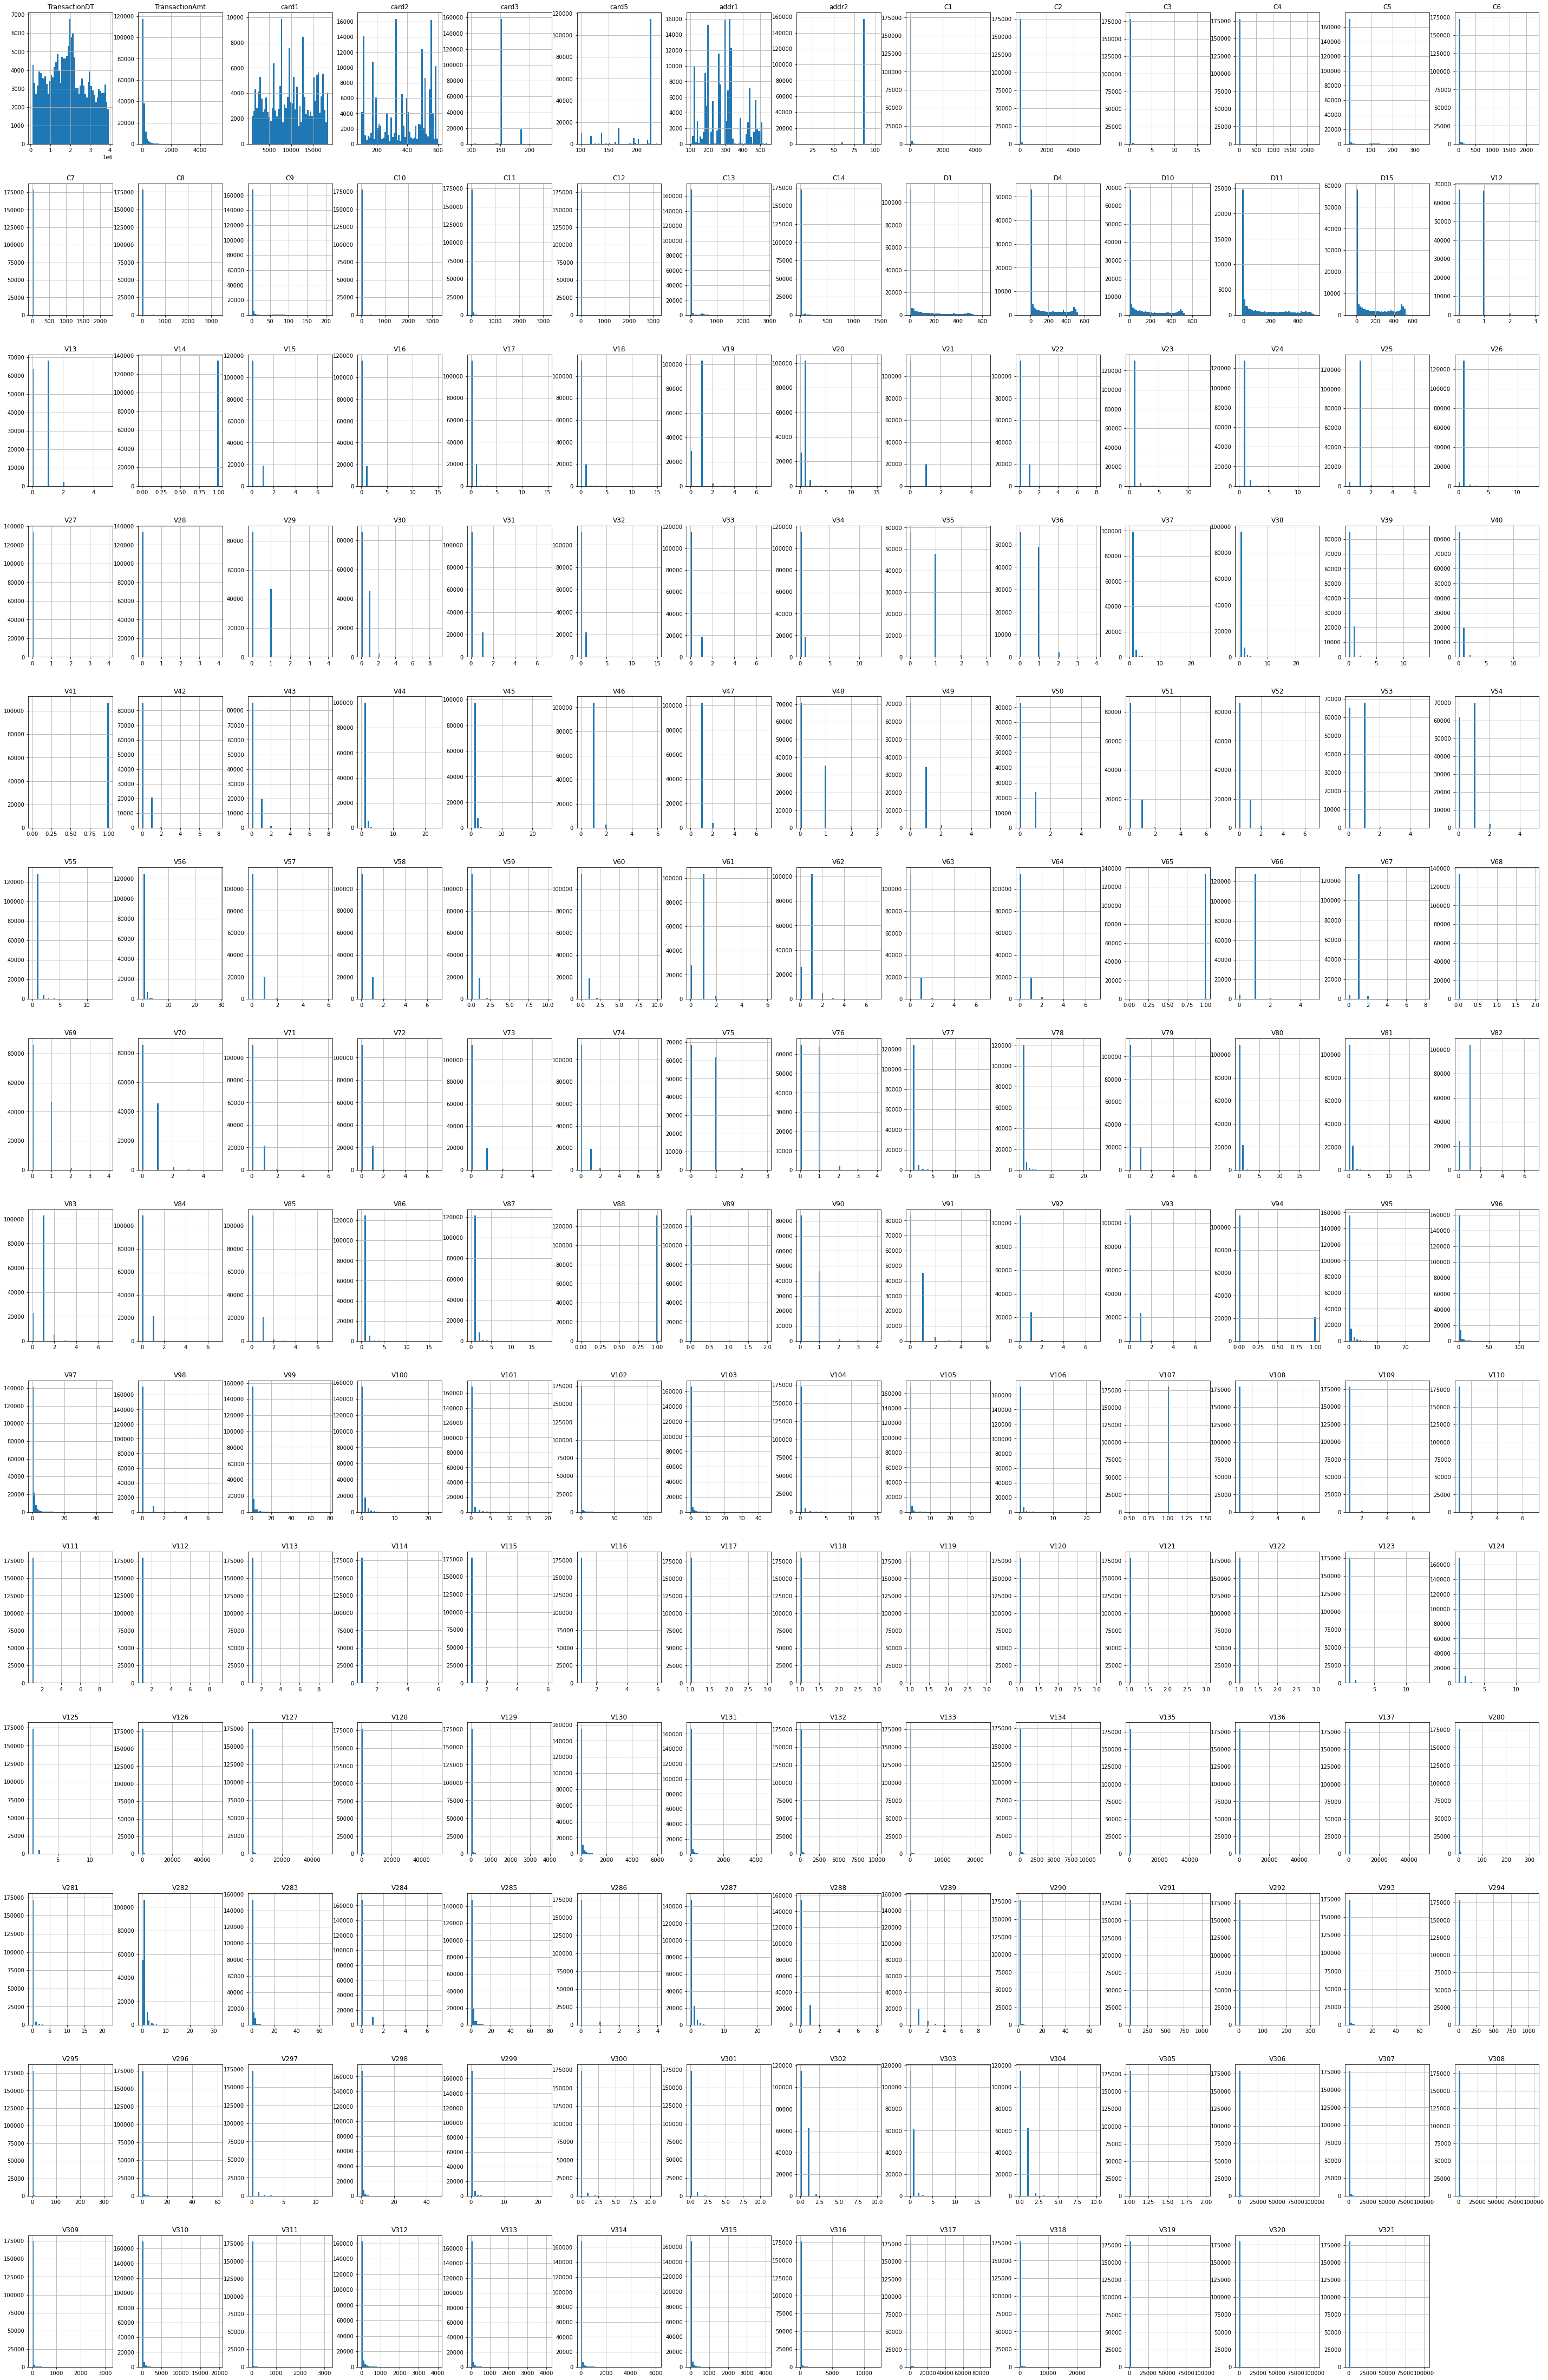

In [24]:
df_num_features = df_train[numerical_features]
df_num_features.hist(figsize=(50, 80), bins=50, grid=True)
# для более подробного анализа графиков, можно выводить гистограммы для небольших груп признаков

In [25]:
#df_num_features = df_train[numerical_features_1]
#df_num_features.hist(figsize=(50, 80), bins=50, grid=True)

In [26]:
#pd.set_option('display.max_rows', 50)
#df_num_features = df_train[numerical_features_2]
#df_num_features.hist(figsize=(50, 80), bins=50, grid=True)

In [27]:
#df_num_features = df_train[numerical_features_3]
#df_num_features.hist(figsize=(50, 80), bins=50, grid=True)

In [28]:
#df_num_features = df_train[numerical_features_4]
#df_num_features.hist(figsize=(25, 50), bins=50, grid=True)

In [29]:
#train_num_features = []
#train_num_features = train[numerical_features]
#print(f"Continuous Feature Count {len(numerical_features)}")

In [30]:
#df_num_features = df_train.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32'])

#df_num_features.hist(figsize=(25, 150), bins=50, grid=True)

## Задание 1:<a class="anchor" id="task1"></a>

Отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [31]:
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [32]:
data = df_train[numerical_features]
target = df_train["isFraud"]

print(data.shape)
print(target.shape)

(180000, 195)
(180000,)


In [33]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 195 cols
x_valid.shape = 36000 rows, 195 cols


In [34]:
#data.head(10)

**XGBoost API**

In [35]:
# Задача бинарной классификации
params = {
    "booster": "gbtree",  # бостинг над решающими деревьями (1:14:25)
    "objective": "binary:logistic", # бинарная крос-энтропия
    "eval_metric": "auc",  # метрика качества - ROC AUC
    "learning_rate": 0.1,  # скорсть обучения
    "n_estimators": 1000,  # число деревьев
     # регуляризация
    "reg_lambda": 100,  # регуляризация (то что используется при F2-штрафе (1:15:10))
    "max_depth": 4,  # глубина дерева
    "gamma": 10,  # min-е улучшение функции потерь при котором мы будем делать разбиени (1:15:40)
    "nthread": 6, # число ядер
    "seed": 27
}

In [36]:
# DMatrix - специальный формат данных XGBoost API
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)

dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [37]:
model = xgb.train(
    params=params,
    dtrain=dtrain,  #dmatrix - наш dataframe
    num_boost_round=1000,  # max кол-во итераций, к! мы готовы ждать, обычно ~10000
    early_stopping_rounds=50, # max кол-во итераций к! мы ждём, если качаство не увеличивается
    evals=[(dtrain, "train"), (dvalid, "valid")],  # выборки на к! мы отслеживаем качество
    verbose_eval=50,  # Как часто выводим на экран статистику
    maximize=True,  # True -Чем выше значение метрики , тем она лучше
)

[23:22:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.61944	valid-auc:0.61748
[50]	train-auc:0.88098	valid-auc:0.87410
[100]	train-auc:0.89956	valid-auc:0.88869
[150]	train-auc:0.90526	valid-auc:0.89390
[200]	train-auc:0.90734	valid-auc:0.89603
[222]	train-auc:0.90734	valid-auc:0.89603


<AxesSubplot:>

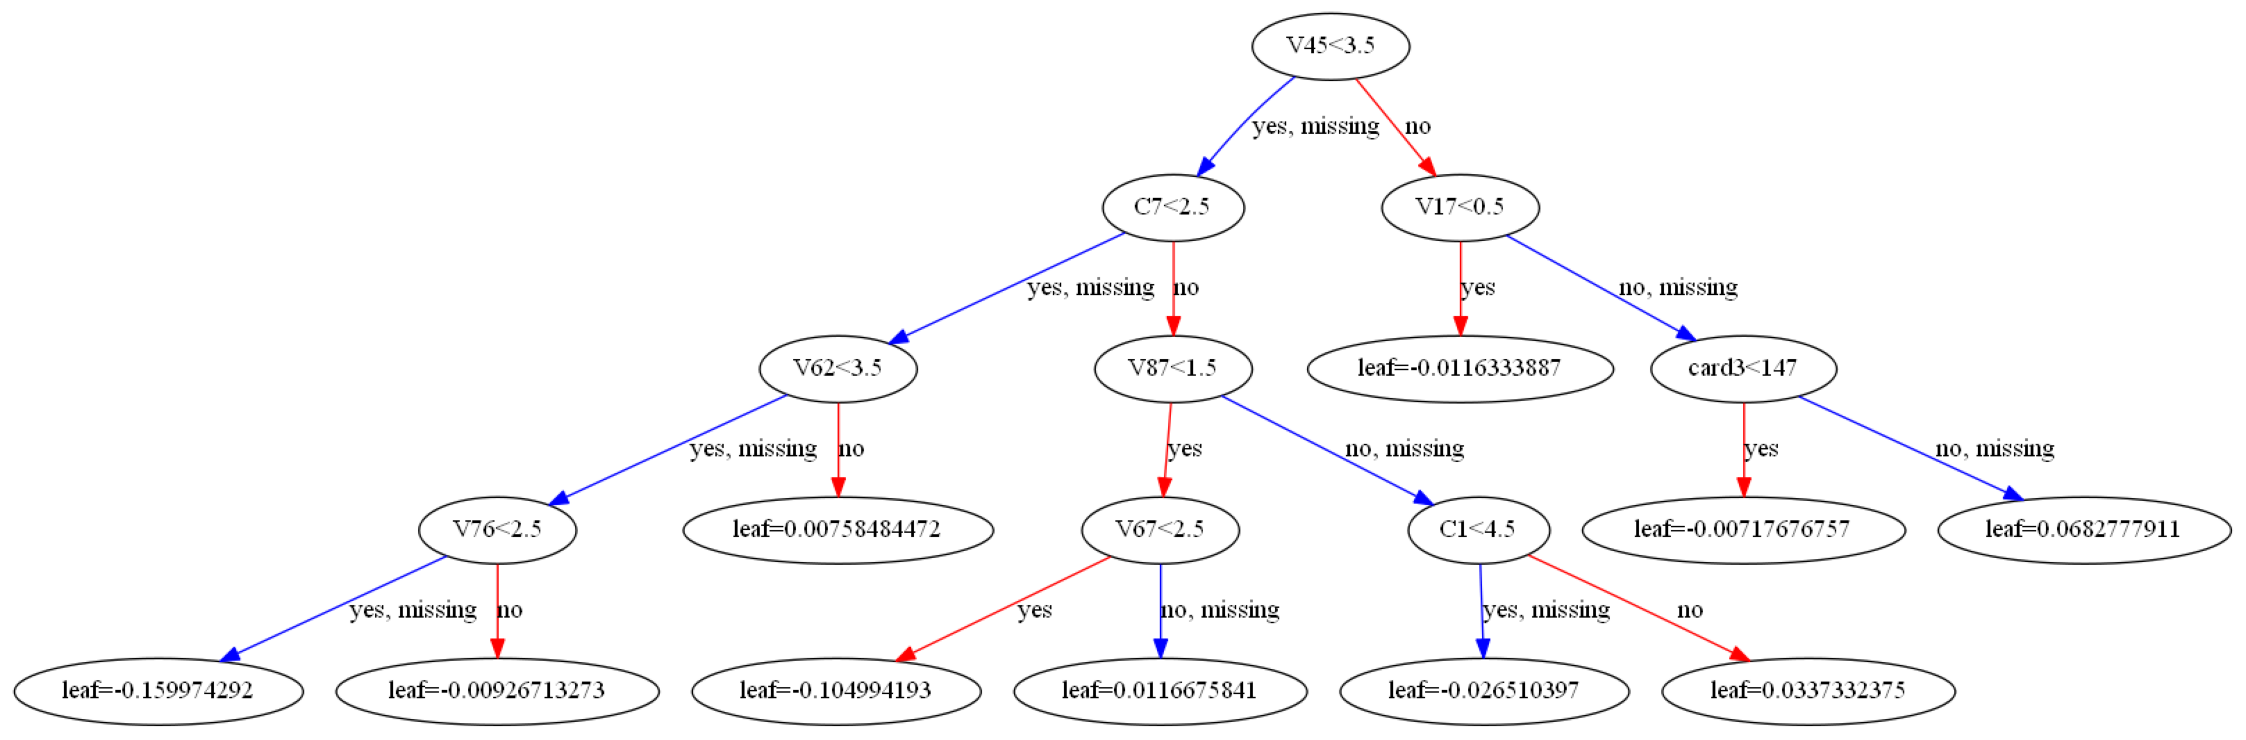

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(40, 40))
xgb.plot_tree(model, num_trees=2, ax=axes)

In [39]:
#fig, axes = plt.subplots(1, 1, figsize=(40, 40))
#xgb.plot_tree(model, num_trees=2, ax=axes, rankdir='LR')

**XGBoost Linear**

In [40]:
params = {
    "booster": "gblinear",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27,
    #"target_type_": "BINARY"
}

In [41]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    early_stopping_rounds=50,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=50,
    maximize=True,
)

[23:23:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { gamma, max_depth, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.57739	valid-auc:0.58001
[50]	train-auc:0.70224	valid-auc:0.70682
[100]	train-auc:0.70739	valid-auc:0.71209
[150]	train-auc:0.71012	valid-auc:0.71480
[200]	train-auc:0.71218	valid-auc:0.71679
[250]	train-auc:0.71379	valid-auc:0.71839
[300]	train-auc:0.71508	valid-auc:0.71966
[350]	train-auc:0.71612	valid-auc:0.72068
[400]	train-auc:0.71697	valid-auc:0.72153
[450]	train-auc:0.71766	valid-auc:0.72222
[500]	train-auc:0.71823	valid-auc:0.72279
[550]	train-auc:0.71870	valid-auc:0.72325
[600]	train-auc:0.71909	valid-auc:0.72364
[650]	train-auc:0.71942	valid-auc:0.72396
[700]	t

**XGBoost Cross-Validation**

In [42]:
cv_result = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=50,
    stratified=True,  # Стратифицированное разбиение (1:23:40)
    metrics="auc",
    maximize=True,
    shuffle=True, # Нужно перемешивать или нет
    nfold=3,  # кол-во фолдов кросвалидации (1:23:50)
)

[23:26:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { gamma, max_depth, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { gamma, max_depth, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:26:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { gamma, max_depth, n_estimators } might not be used.

  This may not 

In [43]:
cv_result

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.578999       0.002918       0.579163      0.003918
1          0.586861       0.003081       0.586678      0.004061
2          0.606123       0.003416       0.605677      0.003996
3          0.626972       0.002903       0.626617      0.005459
4          0.640686       0.002669       0.640145      0.005501
..              ...            ...            ...           ...
995        0.721022       0.002743       0.719283      0.002636
996        0.721024       0.002743       0.719285      0.002636
997        0.721026       0.002743       0.719287      0.002636
998        0.721028       0.002743       0.719289      0.002637
999        0.721029       0.002744       0.719290      0.002637

[1000 rows x 4 columns]

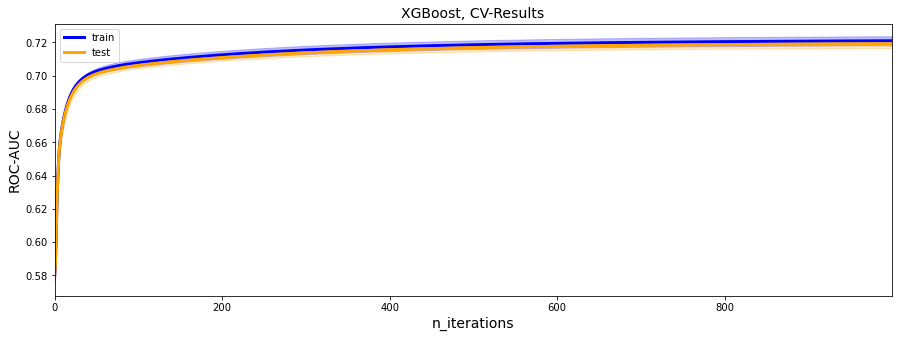

In [44]:
# Построение доверительного интервала
fig = plt.figure(figsize=(15, 5))
plt.plot(cv_result["train-auc-mean"], color="blue", linewidth=3, label="train")
plt.plot(cv_result["test-auc-mean"], color="orange", linewidth=3, label="test")
plt.fill_between( # метод позволяет построить доверительный интервал 
    x=cv_result.index,  # то что мы хотим отложить (1:28:03)
    y1=cv_result["train-auc-mean"] - cv_result["train-auc-std"],  # границы доверительного интервала
    y2=cv_result["train-auc-mean"] + cv_result["train-auc-std"],  # границы доверительного интервала
    alpha=0.25, color="blue"
)
plt.fill_between(
    x=cv_result.index,
    y1=cv_result["test-auc-mean"] - cv_result["test-auc-std"],
    y2=cv_result["test-auc-mean"] + cv_result["test-auc-std"],
    alpha=0.25, color="orange"
)
plt.title("XGBoost, CV-Results", size=14)
plt.xlabel("n_iterations", size=14)
plt.xlim(0, cv_result.index.max())
plt.ylabel("ROC-AUC", size=14)
plt.legend(loc="best")

**XGBoost sklearn-API**

In [45]:
model = xgb.XGBClassifier(**params)
model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=50
)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:29:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { gamma, max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.57697	validation_1-auc:0.57932
[50]	validation_0-auc:0.70223	validation_1-auc:0.70680
[100]	validation_0-auc:0.70739	validation_1-auc:0.71208
[150]	validation_0-auc:0.71012	validation_1-auc:0.71480
[200]	validation_0-auc:0.71217	validation_1-auc:0.71679
[250]	validation_0-auc:0.71379	validation_1-auc:0.71838
[300]	validation_0-auc:0.71508	validation_1-auc:0.71966
[350]	validation_0-auc:0.71612	validation_1-auc:0.72068
[400]	validation_0-auc:0.71697	validation_1-auc:0.72153
[450]	validation_0-auc:0.71766	validation_1-auc:0.72223
[500]	validation_0-auc:0.71823	validation_1-auc:0

XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.1,
              max_delta_step=None, max_depth=4, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=1000,
              n_jobs=6, nthread=6, num_parallel_tree=None, random_state=27,
              reg_alpha=0, reg_lambda=100, scale_pos_weight=1, seed=27,
              subsample=None, tree_method=None, validate_parameters=1,
              verbosity=None)

### ROCAUC - https://rebeccabilbro.github.io/xgboost-and-yellowbrick/

In [46]:
#!pip install yellowbrick

In [47]:
#from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
#rocauc = ROCAUC(model, size=(1080, 720), classes=numerical_features)

#rocauc.score(x_valid, y_valid)  
#r = rocauc.poof()

# Задание 2:<a class="anchor" id="task2"></a>

***Обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.***

XGBoost В отличие от CatBoost или LGBM, XGBoost не может обрабатывать категориальные функции сам по себе, он принимает только числовые значения.

Все о категориальном кодировании переменных - https://www.machinelearningmastery.ru/all-about-categorical-variable-encoding-305f3361fd02/


### 2.1 Обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. 

In [48]:
df_train.select_dtypes(include='object').columns
df_train.select_dtypes(include='category').columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'], dtype='object')

In [49]:
catigorical_features = [
'ProductCD',  # 180000 non-null  category
'card4',  # 179992 non-null  category
'card6',  # 179993 non-null  category
'P_emaildomain',  # 151560 non-null  category
'R_emaildomain',  # 60300 non-null   category
'M1',  # 61749 non-null   category
'M2',  # 61749 non-null   category
'M3',  # 61749 non-null   category
'M4',  # 83276 non-null   category
'M5',  # 61703 non-null   category
'M6',  # 105652 non-null  category
'M7',  # 31652 non-null   category
'M8',  # 31652 non-null   category
'M9'  # 31652 non-null   category
]
#catigorical_features_1 = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [50]:
data = []
data = df_train[numerical_features + catigorical_features]
#data = df_train[catigorical_features]

In [51]:
print(data.shape)

(180000, 209)


**Приведение типов**

In [52]:
#for colname in catigorical_features:
#     df_train[colname] = df_train[colname].astype(str)

#df_train['ProductCD'] = df_train['ProductCD'].astype(str)

In [53]:
data[catigorical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   ProductCD      180000 non-null  category
 1   card4          179992 non-null  category
 2   card6          179993 non-null  category
 3   P_emaildomain  151560 non-null  category
 4   R_emaildomain  60300 non-null   category
 5   M1             61749 non-null   category
 6   M2             61749 non-null   category
 7   M3             61749 non-null   category
 8   M4             83276 non-null   category
 9   M5             61703 non-null   category
 10  M6             105652 non-null  category
 11  M7             31652 non-null   category
 12  M8             31652 non-null   category
 13  M9             31652 non-null   category
dtypes: category(14)
memory usage: 2.4 MB


In [54]:
data[catigorical_features].isna().sum()  # просматриваем пропуски

ProductCD             0
card4                 8
card6                 7
P_emaildomain     28440
R_emaildomain    119700
M1               118251
M2               118251
M3               118251
M4                96724
M5               118297
M6                74348
M7               148348
M8               148348
M9               148348
dtype: int64

**Оработка пропусков в категориалиных признаках**


In [55]:
# заполняем пропуски в категориалиных признаках
for feature in catigorical_features:
    data[feature] = data[feature].cat.add_categories('Unknown')
    data[feature].fillna('Unknown', inplace =True) 

<ipython-input-55-cb6ea9ab320f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature] = data[feature].cat.add_categories('Unknown')
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


**Обзор значений категориальных признаков**

In [56]:
#cat_colname = 'ProductCD'
#print(str(cat_colname) + '\n\n' + str(data[cat_colname].value_counts()))

In [57]:
for cat_colname in data[catigorical_features].columns:
    print(str(cat_colname) + '\n\n' + str(data[cat_colname].value_counts()) + '\n' + '*' * 40 + '\n')

ProductCD

W          110340
H           22422
R           21926
C           21664
S            3648
Unknown         0
Name: ProductCD, dtype: int64
****************************************

card4

visa                118295
mastercard           54501
american express      4818
discover              2378
Unknown                  8
Name: card4, dtype: int64
****************************************

card6

debit              122746
credit              57229
debit or credit        10
charge card             8
Unknown                 7
Name: card6, dtype: int64
****************************************

P_emaildomain

gmail.com           67198
yahoo.com           28992
Unknown             28440
hotmail.com         15058
anonymous.com       13328
aol.com              8583
comcast.net          2916
icloud.com           1677
outlook.com          1484
msn.com              1423
att.net              1223
sbcglobal.net        1092
verizon.net           971
live.com              894
bellsouth.net  

In [58]:
data[catigorical_features].isna().sum()  # просматриваем пропуски

ProductCD        0
card4            0
card6            0
P_emaildomain    0
R_emaildomain    0
M1               0
M2               0
M3               0
M4               0
M5               0
M6               0
M7               0
M8               0
M9               0
dtype: int64

In [59]:
data[catigorical_features].head()

ProductCD       card4   card6 P_emaildomain R_emaildomain       M1       M2       M3       M4       M5       M6       M7       M8       M9
0         W    discover  credit       Unknown       Unknown        T        T        T       M2        F        T  Unknown  Unknown  Unknown
1         W  mastercard  credit     gmail.com       Unknown  Unknown  Unknown  Unknown       M0        T        T  Unknown  Unknown  Unknown
2         W        visa   debit   outlook.com       Unknown        T        T        T       M0        F        F        F        F        F
3         W  mastercard   debit     yahoo.com       Unknown  Unknown  Unknown  Unknown       M0        T        F  Unknown  Unknown  Unknown
4         H  mastercard  credit     gmail.com       Unknown  Unknown  Unknown  Unknown  Unknown  Unknown  Unknown  Unknown  Unknown  Unknown

In [60]:
#for c in catigorical_features:
#    print(data[c].unique())

In [61]:
# Каждой категории сопоставляет целое число (номер категории) - https://dyakonov.org/2016/08/03/python-категориальные-признаки/
from sklearn.preprocessing import LabelEncoder
'''
le = LabelEncoder()
le.fit(data.ProductCD)
data['ProductCD_le'] = le.transform(data.ProductCD)
print(str('ProductCD_le') + '\n\n' + str(data[cat_colname].value_counts()) + str(data['ProductCD'].value_counts()))
'''

"\nle = LabelEncoder()\nle.fit(data.ProductCD)\ndata['ProductCD_le'] = le.transform(data.ProductCD)\nprint(str('ProductCD_le') + '\n\n' + str(data[cat_colname].value_counts()) + str(data['ProductCD'].value_counts()))\n"

In [62]:
le = LabelEncoder()
for cat_colname in data[catigorical_features].columns:
    le.fit(data[cat_colname])
    data[cat_colname+'_le'] = le.transform(data[cat_colname])

<ipython-input-62-450a2fdcc54b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cat_colname+'_le'] = le.transform(data[cat_colname])


In [63]:
le = LabelEncoder()
for cat_colname in data[catigorical_features].columns:
    print(str(cat_colname+'_le') + '\n\n' + str(data[cat_colname+'_le'].value_counts()) + '\n' + '*' * 40 + '\n')

ProductCD_le

4    110340
1     22422
2     21926
0     21664
3      3648
Name: ProductCD_le, dtype: int64
****************************************

card4_le

4    118295
3     54501
1      4818
2      2378
0         8
Name: card4_le, dtype: int64
****************************************

card6_le

3    122746
2     57229
4        10
1         8
0         7
Name: card6_le, dtype: int64
****************************************

P_emaildomain_le

17    67198
54    28992
0     28440
20    15058
2     13328
3      8583
10     2916
24     1677
36     1484
32     1423
4      1223
44     1092
49      971
26      894
5       713
59      654
31      624
11      570
55      522
9       372
35      362
27      254
29      214
43      201
12      173
30      147
37      142
42      119
16      115
25      111
13      109
51       95
48       86
22       85
14       79
23       68
41       68
33       65
50       64
1        63
38       62
8        59
15       59
7        49
34       49
47       45

In [64]:
data[catigorical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   ProductCD      180000 non-null  category
 1   card4          180000 non-null  category
 2   card6          180000 non-null  category
 3   P_emaildomain  180000 non-null  category
 4   R_emaildomain  180000 non-null  category
 5   M1             180000 non-null  category
 6   M2             180000 non-null  category
 7   M3             180000 non-null  category
 8   M4             180000 non-null  category
 9   M5             180000 non-null  category
 10  M6             180000 non-null  category
 11  M7             180000 non-null  category
 12  M8             180000 non-null  category
 13  M9             180000 non-null  category
dtypes: category(14)
memory usage: 2.4 MB


## 2.2 Повторно выполняем задание 1 (с учётом категориальных признаков)

In [65]:
data_new = data
data_new = data_new.drop(catigorical_features, axis=1)

data_new.columns

Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'C1', 'C2',
       ...
       'R_emaildomain_le', 'M1_le', 'M2_le', 'M3_le', 'M4_le', 'M5_le', 'M6_le', 'M7_le', 'M8_le', 'M9_le'], dtype='object', length=209)

In [66]:
target = df_train["isFraud"]

In [67]:
x_train, x_valid = train_test_split(
    data_new, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 209 cols
x_valid.shape = 36000 rows, 209 cols


In [68]:
# Задача бинарной классификации
params = {
    "booster": "gbtree",  # бостинг над решающими деревьями (1:14:25)
    "objective": "binary:logistic", # бинарная крос-энтропия
    "eval_metric": "auc",  # метрика качества - ROC AUC
    "learning_rate": 0.1,  # скорсть обучения
    "n_estimators": 1000,  # число деревьев
     # регуляризация
    "reg_lambda": 100,  # регуляризация (то что используется при F2-штрафе (1:15:10))
    "max_depth": 4,  # глубина дерева
    "gamma": 10,  # min-е улучшение функции потерь при котором мы будем делать разбиени (1:15:40)
    "nthread": 6, # число ядер
    "seed": 27
}

In [69]:
# DMatrix - специальный формат данных XGBoost API
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)

dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [70]:
model = xgb.train(
    params=params,
    dtrain=dtrain,  #dmatrix - наш dataframe
    num_boost_round=1000,  # max кол-во итераций, к! мы готовы ждать, обычно ~10000
    early_stopping_rounds=50, # max кол-во итераций к! мы ждём, если качаство не увеличивается
    evals=[(dtrain, "train"), (dvalid, "valid")],  # выборки на к! мы отслеживаем качество
    verbose_eval=50,  # Как часто выводим на экран статистику
    maximize=True,  # True -Чем выше значение метрики , тем она лучше
)

[23:30:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.61944	valid-auc:0.61748
[50]	train-auc:0.88791	valid-auc:0.88177
[100]	train-auc:0.90881	valid-auc:0.89788
[150]	train-auc:0.91700	valid-auc:0.90469
[200]	train-auc:0.91819	valid-auc:0.90576
[211]	train-auc:0.91819	valid-auc:0.90576


<AxesSubplot:>

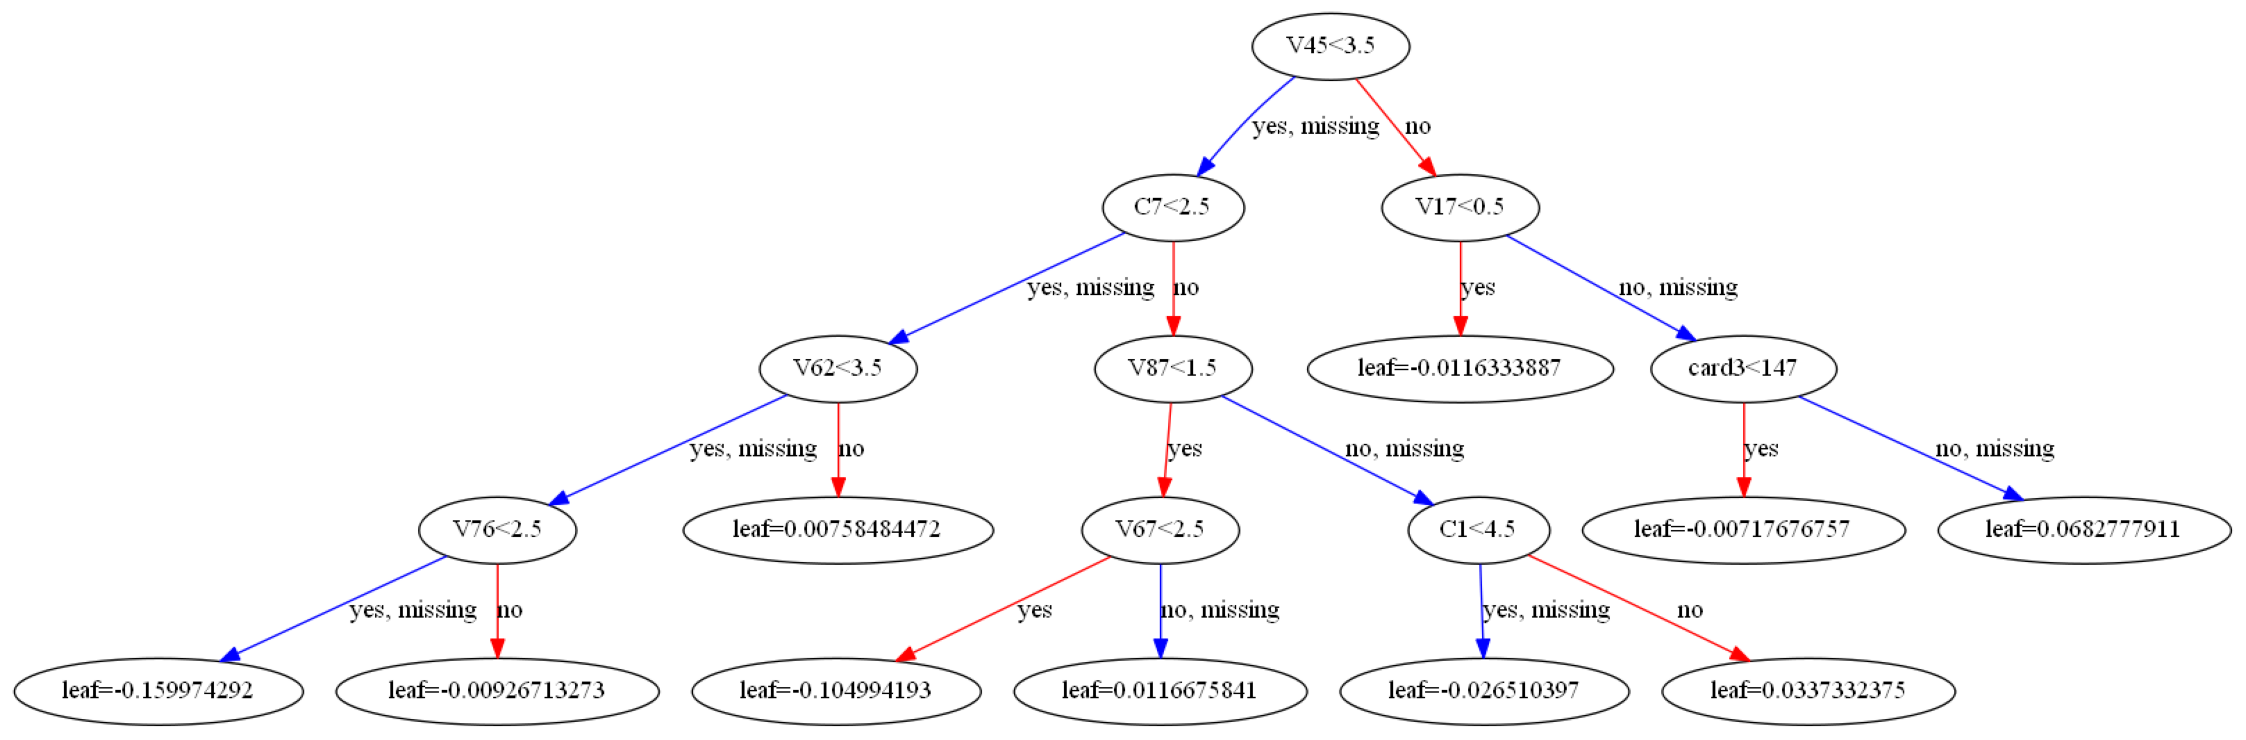

In [71]:
fig, axes = plt.subplots(1, 1, figsize=(40, 40))
xgb.plot_tree(model, num_trees=2, ax=axes)

## Результат

**Было** (значение из Задания 1 без учёта категориальных признаков):

    [200]	train-auc:0.90734	valid-auc:0.89603

**Стало** (с учётом категориальных признаков):

    [200]	train-auc:0.91819	valid-auc:0.90576


### Вывод:
    1. XGBoost - не умеет самостоятельно обрабатывать категориальные признаки, поэтому их необходимо обрабатывать вручную.
    2. Значение метрики качества модели увеличилось с - {[200]  train-auc:0.90734  valid-auc:0.89603}, для набора данных
    в котором не использавались категориальные признаки, до значений - {[200]  train-auc:0.91819  valid-auc:0.90576}.

    Таким образом использование обработанных категориальных признаков, позволило достигнуть лучшего результата.
    

# Задание 4:<a class="anchor" id="task4"></a>

Для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно)

In [72]:
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [73]:
data = df_train[numerical_features]
#data = data.drop(["TransactionID", "isFraud"], axis=1)
target = df_train["isFraud"]

print("data.shape = {} rows, {} cols".format(*data.shape))
print(data.shape)
print(target.shape)

data.shape = 180000 rows, 195 cols
(180000, 195)
(180000,)


In [74]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 195 cols
x_valid.shape = 36000 rows, 195 cols


### LightGBM API

In [75]:
params = {
    "boosting_type": "gbdt",  # gradient boosting tree decision tree
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 200,  # число деревьев
    "n_jobs": 6,
    "seed": 27
}

In [76]:
dtrain = lgb.Dataset(
    data=x_train, label=y_train
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10
)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 4139, number of negative: 139861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15073
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028743 -> initscore=-3.520195
[LightGBM] [Info] Start training from score -3.520195
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.829902	valid_1's auc: 0.829728
[20]	training's auc: 0.859873	valid_1's auc: 0.857996
[30]	training's auc: 0.86686	valid_1's auc: 0.860833
[40]	training's auc: 0.869993	valid_1's auc: 0.862705
[50]	training's auc: 0.872168	valid_1's auc: 0.863933
[60]	training's auc: 0.876123	valid_1's auc: 0.86884
[70]	training's auc: 0.880097	valid_1's auc: 0.873166

In [77]:
params["boosting_type"] = "goss"

model = lgb.train(
    params=params,  # GOSS - Gradient Based One Side Sampling (случайный отбор на основе градиентов)
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10
)

[LightGBM] [Info] Number of positive: 4139, number of negative: 139861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15073
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 193
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028743 -> initscore=-3.520195
[LightGBM] [Info] Start training from score -3.520195
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.829902	valid_1's auc: 0.829728
[20]	training's auc: 0.859873	valid_1's auc: 0.857996
[30]	training's auc: 0.86686	valid_1's auc: 0.860833
[40]	training's auc: 0.869993	valid_1's auc: 0.862705
[50]	training's auc: 0.872168	valid_1's auc: 0.863933
[60]	training's auc: 0.876123	valid_1's auc: 0.86884
[70]	training's auc: 0.8

### LightGBM Cross-Validation

In [78]:
cv_result = lgb.cv(
    params=params,
    train_set=dtrain,
    num_boost_round=200,
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10,
    stratified=True,
    shuffle=True,
    nfold=5, 
)

[LightGBM] [Info] Number of positive: 3312, number of negative: 111888


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15073
[LightGBM] [Info] Number of data points in the train set: 115200, number of used features: 193
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Number of positive: 3311, number of negative: 111889
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15073
[LightGBM] [Info] Number of data points in the train set: 115200, number of used features: 193
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Number of positive: 3311, number of negative: 111889
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testi

In [79]:
cv_result

{'auc-mean': [0.7767344021563523,
  0.7813921893780746,
  0.7881130202738797,
  0.7974385108839965,
  0.8095428652804602,
  0.8129991309656089,
  0.8164208967704789,
  0.817641476781113,
  0.818318094269275,
  0.8195217860156259,
  0.8225287398645305,
  0.8227115335726687,
  0.8230399114195862,
  0.8244361301980682,
  0.8314746147243863,
  0.8376470766758211,
  0.8381938228426478,
  0.8418451271532108,
  0.8420269526176115,
  0.8421580546645929,
  0.8423380798676522,
  0.843646856064117,
  0.8438348007993663,
  0.8498455031275454,
  0.850058736209591,
  0.8504085592679029,
  0.8519331271855934,
  0.8524526893680988,
  0.8529344360732114,
  0.8532770303518109,
  0.8539462670985198,
  0.8583092043713381,
  0.8594905634732249,
  0.8599339397076452,
  0.860181092019803,
  0.8616328597825895,
  0.8618030897611263,
  0.8624460536265065,
  0.8628438671335321,
  0.863213338688792,
  0.8634205323995687,
  0.864164616999127,
  0.8643234862358483,
  0.8645933261642013,
  0.8649871470884483,
  0.8

### LightGBM Sklearn-API

In [80]:
model = lgb.LGBMClassifier(**params)
y = model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=10
)
print('-'*50)
print(y)

Training until validation scores don't improve for 25 rounds
[10]	training's auc: 0.829902	valid_1's auc: 0.829728
[20]	training's auc: 0.859873	valid_1's auc: 0.857996
[30]	training's auc: 0.86686	valid_1's auc: 0.860833
[40]	training's auc: 0.869993	valid_1's auc: 0.862705
[50]	training's auc: 0.872168	valid_1's auc: 0.863933
[60]	training's auc: 0.876123	valid_1's auc: 0.86884
[70]	training's auc: 0.880097	valid_1's auc: 0.873166
[80]	training's auc: 0.882318	valid_1's auc: 0.874728
[90]	training's auc: 0.885935	valid_1's auc: 0.878646
[100]	training's auc: 0.889005	valid_1's auc: 0.880191
[110]	training's auc: 0.892023	valid_1's auc: 0.88333
[120]	training's auc: 0.895691	valid_1's auc: 0.885122
[130]	training's auc: 0.897215	valid_1's auc: 0.88681
[140]	training's auc: 0.898855	valid_1's auc: 0.887692
[150]	training's auc: 0.900143	valid_1's auc: 0.889119
[160]	training's auc: 0.902012	valid_1's auc: 0.890495
[170]	training's auc: 0.904004	valid_1's auc: 0.891495
[180]	training's 

# Задание 5:<a class="anchor" id="task5"></a>

Обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4

**Обрабатывае категориальные признаки также как и XGBoost**

In [81]:
data = []
data = df_train[numerical_features + catigorical_features]

# заполняем пропуски в категориалиных признаках
for feature in catigorical_features:
    data[feature] = data[feature].cat.add_categories('Unknown')
    data[feature].fillna('Unknown', inplace =True) 
    
# Каждой категории сопоставляет целое число (номер категории) - https://dyakonov.org/2016/08/03/python-категориальные-признаки/
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for cat_colname in data[catigorical_features].columns:
    le.fit(data[cat_colname])
    data[cat_colname+'_le'] = le.transform(data[cat_colname])
    

<ipython-input-81-56759bab4f67>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature] = data[feature].cat.add_categories('Unknown')
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-81-56759bab4f67>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [82]:
####
data_new = data
data_new = data_new.drop(catigorical_features, axis=1)

data_new.columns

Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'C1', 'C2',
       ...
       'R_emaildomain_le', 'M1_le', 'M2_le', 'M3_le', 'M4_le', 'M5_le', 'M6_le', 'M7_le', 'M8_le', 'M9_le'], dtype='object', length=209)

In [83]:
x_train, x_valid = train_test_split(
    data_new, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 209 cols
x_valid.shape = 36000 rows, 209 cols


In [84]:
dtrain = lgb.Dataset(
    data=x_train, label=y_train
)
dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

model = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10
)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 4139, number of negative: 139861
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15236
[LightGBM] [Info] Number of data points in the train set: 144000, number of used features: 207
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028743 -> initscore=-3.520195
[LightGBM] [Info] Start training from score -3.520195
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.830267	valid_1's auc: 0.830224
[20]	training's auc: 0.85899	valid_1's auc: 0.858742
[30]	training's auc: 0.868745	valid_1's auc: 0.865245
[40]	training's auc: 0.871826	valid_1's auc: 0.866352
[50]	training's auc: 0.877573	valid_1's auc: 0.871756
[60]	training's auc: 0.880594	valid_1's auc: 0.874296
[70]	training's auc: 0.

In [85]:
cv_result = lgb.cv(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10,
    stratified=True,
    shuffle=True,
    nfold=5, 
)

[LightGBM] [Info] Number of positive: 3312, number of negative: 111888


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:530: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15236
[LightGBM] [Info] Number of data points in the train set: 115200, number of used features: 207
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Number of positive: 3311, number of negative: 111889
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15236
[LightGBM] [Info] Number of data points in the train set: 115200, number of used features: 207
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Number of positive: 3311, number of negative: 111889
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testi

In [86]:
cv_result

{'auc-mean': [0.776732105173379,
  0.7813907812101026,
  0.7880309351449395,
  0.7972522606708969,
  0.8054336055619178,
  0.8126760744552666,
  0.8158976570201389,
  0.8176204301180772,
  0.8182379659283499,
  0.8200505296922083,
  0.8205130605204612,
  0.820819269417251,
  0.823710008479857,
  0.8245248204159173,
  0.8349770727876745,
  0.8439672477441397,
  0.8447880912384381,
  0.8460303064549249,
  0.8464812031077417,
  0.8464907777053909,
  0.8471643724123308,
  0.847864207779032,
  0.8483809473569567,
  0.8558238033320006,
  0.8564056209361685,
  0.8571875284047034,
  0.8575130759597943,
  0.8577657373713825,
  0.857848322168065,
  0.8580715214691503,
  0.8590954607358098,
  0.860090232400949,
  0.8608272709446579,
  0.8611936986518416,
  0.8612846950127458,
  0.8619385435518663,
  0.8621874950680007,
  0.8623911627922037,
  0.8624036793780265,
  0.8628283573758232,
  0.8627586264490837,
  0.8630952070952063,
  0.8632437590029667,
  0.8635536506777276,
  0.8644823630704384,
  0.

## Результат

**Было** (значение из Задания 4 (LightGBM Cross-Validation) без учёта категориальных признаков):

    [200]	training's auc: 0.906055	valid_1's auc: 0.893405
    [200]	cv_agg's auc: 0.893526 + 0.00634967 # LightGBM   ([200] train-auc:0.90734 valid-auc:0.89603 # XGBoost)

**Стало** (с учётом категориальных признаков):
    
    [200]	training's auc: 0.915969	valid_1's auc: 0.901176
    [200]	cv_agg's auc: 0.901872 + 0.00498726 # LightGBM    ([200] train-auc:0.91819 valid-auc:0.90576 # XGBoost)


### Вывод:
    Значение метрики качества модели увеличилось с - {[200]	cv_agg's auc: 0.893526 + 0.00634967},
    для набора данных в котором не использавались категориальные признаки,
    до значений - {[200]	cv_agg's auc: 0.901872 + 0.00498726}.

    Таким образом использование обработанных категориальных признаков, позволило достигнуть лучшего результата.

# Задание 6:<a class="anchor" id="task6"></a>

Обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5

### LightGBM Sklearn-API c обработанными вручную категориальными признаками (задание 5)

In [87]:
# Выполним LightGBM Sklearn-API для применения в задание 6
model = lgb.LGBMClassifier(**params)
model.fit(
    X=x_train,  # используем обработанный датафрэйм из предыдущего занятия
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=10
)

Training until validation scores don't improve for 25 rounds
[10]	training's auc: 0.830267	valid_1's auc: 0.830224
[20]	training's auc: 0.85899	valid_1's auc: 0.858742
[30]	training's auc: 0.868745	valid_1's auc: 0.865245
[40]	training's auc: 0.871826	valid_1's auc: 0.866352
[50]	training's auc: 0.877573	valid_1's auc: 0.871756
[60]	training's auc: 0.880594	valid_1's auc: 0.874296
[70]	training's auc: 0.882865	valid_1's auc: 0.875916
[80]	training's auc: 0.884931	valid_1's auc: 0.877509
[90]	training's auc: 0.893909	valid_1's auc: 0.88362
[100]	training's auc: 0.897756	valid_1's auc: 0.886242
[110]	training's auc: 0.900059	valid_1's auc: 0.888187
[120]	training's auc: 0.901987	valid_1's auc: 0.889596
[130]	training's auc: 0.903725	valid_1's auc: 0.890804
[140]	training's auc: 0.904956	valid_1's auc: 0.892603
[150]	training's auc: 0.905909	valid_1's auc: 0.89401
[160]	training's auc: 0.908898	valid_1's auc: 0.896229
[170]	training's auc: 0.909918	valid_1's auc: 0.897507
[180]	training's

LGBMClassifier(boosting_type='goss', learning_rate=0.01, metric='auc',
               n_estimators=200, n_jobs=6, objective='binary', seed=27)

### Обработака категориальных признакав встроенным методом LightGBM (задание 6)

In [88]:
data = []
data = df_train[numerical_features + catigorical_features]

In [89]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 209 cols
x_valid.shape = 36000 rows, 209 cols


### LightGBM Sklearn-API

In [90]:
model = lgb.LGBMClassifier(**params)
model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=10
)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[10]	training's auc: 0.83002	valid_1's auc: 0.829868
[20]	training's auc: 0.859856	valid_1's auc: 0.858051
[30]	training's auc: 0.866844	valid_1's auc: 0.861242
[40]	training's auc: 0.871268	valid_1's auc: 0.865083
[50]	training's auc: 0.877034	valid_1's auc: 0.870163
[60]	training's auc: 0.886489	valid_1's auc: 0.876019
[70]	training's auc: 0.890624	valid_1's auc: 0.878833
[80]	training's auc: 0.893321	valid_1's auc: 0.881282
[90]	training's auc: 0.895349	valid_1's auc: 0.882706
[100]	training's auc: 0.898623	valid_1's auc: 0.885333
[110]	training's auc: 0.900894	valid_1's auc: 0.887276
[120]	training's auc: 0.902637	valid_1's auc: 0.889401
[130]	training's auc: 0.90459	valid_1's auc: 0.891104
[140]	training's auc: 0.906315	valid_1's auc: 0.892637
[150]	training's auc: 0.907901	valid_1's auc: 0.894407
[160]	training's auc: 0.910167	valid_1's auc: 0.896012
[170]	training's auc: 0.911974	valid_1's auc: 0.897424
[180]	training'

LGBMClassifier(boosting_type='goss', learning_rate=0.01, metric='auc',
               n_estimators=200, n_jobs=6, objective='binary', seed=27)

### Результат

**без учёта категориальных признаков:**

    [200]	training's auc: 0.906055	valid_1's auc: 0.893405

    LGBMClassifier(boosting_type='goss', learning_rate=0.01, metric='auc',
                   n_estimators=200, n_jobs=6, objective='binary', seed=27)

**Обработка категориальных признаков вручную (LightGBM Sklearn-API):**

    Best iteration is:
    [200]	training's auc: 0.915969	valid_1's auc: 0.901176
    
    LGBMClassifier(boosting_type='goss', learning_rate=0.01, metric='auc',
                   n_estimators=200, n_jobs=6, objective='binary', seed=27)
               

**Обработать категориальные признаки встроенным методом LightGBM (Sklearn-API):**

    Best iteration is:
    [200]	training's auc: 0.916621	valid_1's auc: 0.901497

    LGBMClassifier(boosting_type='goss', learning_rate=0.01, metric='auc',
                   n_estimators=200, n_jobs=6, objective='binary', seed=27)
               
### Вывод
    
    Значение метрики качества модели незначительно улучшилось.
    [200]	training's auc: 0.906055	valid_1's auc: 0.893405 - без учёта категориальных признаков.
    [200]	training's auc: 0.915969	valid_1's auc: 0.901176 - при обработке категориальных признаков вручную.
    [200]	training's auc: 0.916621	valid_1's auc: 0.901497 - при обработке категориальные признаков 
    встроенным методом LightGBM.

    LightGBM хорошо работает с категориальными признаками даже без их предварительной обработки.
    При обработке категориальных признаков вручную, результат зависит от качества обработки признаков.

# Задание 7:<a class="anchor" id="task7"></a>

Для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [91]:
import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [92]:
data = df_train[numerical_features]
#data = data.drop(["TransactionID", "isFraud"], axis=1)
target = df_train["isFraud"]

print("data.shape = {} rows, {} cols".format(*data.shape))
#print(data.shape)
#print(target.shape)

data.shape = 180000 rows, 195 cols


In [93]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 195 cols
x_valid.shape = 36000 rows, 195 cols


## CatBoost Sklearn-API

In [94]:
cb_params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,  # Как часто выводим на экран статистику
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [95]:
model = cb.CatBoostClassifier(**cb_params)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)])

0:	test: 0.6428916	test1: 0.6337011	best: 0.6337011 (0)	total: 261ms	remaining: 4m 20s
10:	test: 0.7903512	test1: 0.7760513	best: 0.7761566 (9)	total: 1.33s	remaining: 1m 59s
20:	test: 0.8337795	test1: 0.8310485	best: 0.8310485 (20)	total: 2.04s	remaining: 1m 34s
30:	test: 0.8457567	test1: 0.8421181	best: 0.8421181 (30)	total: 2.59s	remaining: 1m 21s
40:	test: 0.8508974	test1: 0.8474832	best: 0.8474832 (40)	total: 3.42s	remaining: 1m 20s
50:	test: 0.8527125	test1: 0.8485145	best: 0.8493058 (41)	total: 4.16s	remaining: 1m 17s
60:	test: 0.8535528	test1: 0.8486150	best: 0.8493058 (41)	total: 4.84s	remaining: 1m 14s
70:	test: 0.8571808	test1: 0.8513373	best: 0.8513373 (70)	total: 5.45s	remaining: 1m 11s
80:	test: 0.8608275	test1: 0.8544776	best: 0.8546970 (79)	total: 6.11s	remaining: 1m 9s
90:	test: 0.8637865	test1: 0.8568108	best: 0.8568108 (90)	total: 6.81s	remaining: 1m 8s
100:	test: 0.8650506	test1: 0.8580264	best: 0.8580264 (100)	total: 7.45s	remaining: 1m 6s
110:	test: 0.8673241	test

In [96]:
model = cb.CatBoostClassifier(**cb_params)
model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6428916	test1: 0.6337011	best: 0.6337011 (0)	total: 117ms	remaining: 1m 57s
10:	test: 0.7903512	test1: 0.7760513	best: 0.7761566 (9)	total: 963ms	remaining: 1m 26s
20:	test: 0.8337795	test1: 0.8310485	best: 0.8310485 (20)	total: 1.63s	remaining: 1m 15s
30:	test: 0.8457567	test1: 0.8421181	best: 0.8421181 (30)	total: 2.28s	remaining: 1m 11s
40:	test: 0.8508974	test1: 0.8474832	best: 0.8474832 (40)	total: 2.9s	remaining: 1m 7s
50:	test: 0.8527125	test1: 0.8485145	best: 0.8493058 (41)	total: 3.44s	remaining: 1m 4s
60:	test: 0.8535528	test1: 0.8486150	best: 0.8493058 (41)	total: 4.04s	remaining: 1m 2s
70:	test: 0.8571808	test1: 0.8513373	best: 0.8513373 (70)	total: 4.6s	remaining: 1m
80:	test: 0.8608275	test1: 0.8544776	best: 0.8546970 (79)	total: 5.2s	remaining: 59.1s
90:	test: 0.8637865	test1: 0.8568108	best: 0.8568108 (90)	total: 5.78s	remaining: 57.7s
100:	test: 0.8650506	test1: 0.8580264	best: 0.8580264 (100)	total: 6.32s	remaining: 56.2s
110:	test: 0.8673241	test1: 0.85981

### Model Cross-Validation

In [97]:
cv_data = cb.cv(
    #cb.Pool(x_train, y_train, cat_features=["var_67_categorical"]),
    cb.Pool(x_train, y_train),
    cb_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6928851	best: 0.6928851 (0)	total: 1.06s	remaining: 17m 38s
10:	test: 0.7842884	best: 0.7842884 (10)	total: 9.15s	remaining: 13m 42s
20:	test: 0.8191439	best: 0.8191439 (20)	total: 17.3s	remaining: 13m 27s
30:	test: 0.8399466	best: 0.8399466 (30)	total: 25.8s	remaining: 13m 27s
40:	test: 0.8470257	best: 0.8470257 (40)	total: 34.3s	remaining: 13m 23s
50:	test: 0.8507300	best: 0.8507300 (50)	total: 43.2s	remaining: 13m 22s
60:	test: 0.8526569	best: 0.8526569 (60)	total: 51.6s	remaining: 13m 14s
70:	test: 0.8540237	best: 0.8541723 (67)	total: 1m	remaining: 13m 7s
80:	test: 0.8551057	best: 0.8551057 (80)	total: 1m 8s	remaining: 12m 57s
90:	test: 0.8569920	best: 0.8569920 (90)	total: 1m 17s	remaining: 12m 55s
100:	test: 0.8585841	best: 0.8585906 (99)	total: 1m 26s	remaining: 12m 48s
110:	test: 0.8595535	best: 0.8595535 (110)	total: 1m 35s	remaining: 12m 45s
120:	test: 0.8611291	best: 0.8611291 (120)	total: 1m 44s	remaining: 12m 40s
130:	test: 0.8637451	best: 0.8637451 (130)	total

In [98]:
cv_data.head()

iterations  test-AUC-mean  test-AUC-std  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  train-Logloss-std
0           0       0.692885      0.002207           0.640846          0.000013            0.640843           0.000025
1           1       0.694013      0.004397           0.596069          0.000037            0.596066           0.000081
2           2       0.723899      0.001748           0.553569          0.000118            0.553566           0.000111
3           3       0.730961      0.007147           0.515403          0.000727            0.515405           0.000706
4           4       0.734457      0.006221           0.480692          0.000363            0.480686           0.000320

In [99]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-AUC-mean']),
    cv_data['test-AUC-std'][np.argmax(cv_data['test-AUC-mean'])],
    np.argmax(cv_data['test-AUC-mean'])
))

Best validation accuracy score: 0.89±0.00 on step 999


## Применение модели

In [100]:
predictions = model.predict(x_valid)
predictions_probs = model.predict_proba(x_valid)

print(predictions[:10])
print(predictions_probs[:10])

[0 0 0 0 0 0 0 0 0 0]
[[0.98311737 0.01688263]
 [0.99512308 0.00487692]
 [0.99578802 0.00421198]
 [0.99354988 0.00645012]
 [0.9808637  0.0191363 ]
 [0.99523593 0.00476407]
 [0.98952062 0.01047938]
 [0.98967758 0.01032242]
 [0.98904561 0.01095439]
 [0.98870075 0.01129925]]


## CatBoost API

In [101]:
#train_pool = cb.Pool(x_train, y_train, cat_features=["var_67_categorical"])
#valid_pool = cb.Pool(x_valid, y_valid, cat_features=["var_67_categorical"])
train_pool = cb.Pool(x_train, y_train)
valid_pool = cb.Pool(x_valid, y_valid)

In [102]:
model = cb.CatBoostClassifier(**cb_params)
model.fit(train_pool, eval_set=valid_pool)

0:	test: 0.6337011	best: 0.6337011 (0)	total: 168ms	remaining: 2m 47s
10:	test: 0.7760513	best: 0.7761566 (9)	total: 1.33s	remaining: 1m 59s
20:	test: 0.8310485	best: 0.8310485 (20)	total: 2s	remaining: 1m 33s
30:	test: 0.8421181	best: 0.8421181 (30)	total: 2.48s	remaining: 1m 17s
40:	test: 0.8474832	best: 0.8474832 (40)	total: 2.98s	remaining: 1m 9s
50:	test: 0.8485145	best: 0.8493058 (41)	total: 3.84s	remaining: 1m 11s
60:	test: 0.8486150	best: 0.8493058 (41)	total: 4.65s	remaining: 1m 11s
70:	test: 0.8513373	best: 0.8513373 (70)	total: 5.22s	remaining: 1m 8s
80:	test: 0.8544776	best: 0.8546970 (79)	total: 5.78s	remaining: 1m 5s
90:	test: 0.8568108	best: 0.8568108 (90)	total: 6.29s	remaining: 1m 2s
100:	test: 0.8580264	best: 0.8580264 (100)	total: 6.78s	remaining: 1m
110:	test: 0.8598111	best: 0.8598719 (109)	total: 7.29s	remaining: 58.4s
120:	test: 0.8606391	best: 0.8606391 (120)	total: 7.79s	remaining: 56.6s
130:	test: 0.8615384	best: 0.8615384 (130)	total: 8.3s	remaining: 55.1s
14

# Задание 8:<a class="anchor" id="task8"></a>

Обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

**Обрабатывае категориальные признаки также как и XGBoost**

In [103]:
data = []
data = df_train[numerical_features + catigorical_features]

# заполняем пропуски в категориалиных признаках
for feature in catigorical_features:
    data[feature] = data[feature].cat.add_categories('Unknown')
    data[feature].fillna('Unknown', inplace =True) 
    
# Каждой категории сопоставляет целое число (номер категории) - https://dyakonov.org/2016/08/03/python-категориальные-признаки/
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for cat_colname in data[catigorical_features].columns:
    le.fit(data[cat_colname])
    data[cat_colname+'_le'] = le.transform(data[cat_colname])

target = df_train["isFraud"]

#train.dtypes

<ipython-input-103-8bac6da628fd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature] = data[feature].cat.add_categories('Unknown')
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-103-8bac6da628fd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [104]:
data_new = data
data_new = data_new.drop(catigorical_features, axis=1)

data_new.columns


Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'C1', 'C2',
       ...
       'R_emaildomain_le', 'M1_le', 'M2_le', 'M3_le', 'M4_le', 'M5_le', 'M6_le', 'M7_le', 'M8_le', 'M9_le'], dtype='object', length=209)

In [105]:
x_train, x_valid = train_test_split(
    data_new, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(    
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 209 cols
x_valid.shape = 36000 rows, 209 cols


In [106]:
model = cb.CatBoostClassifier(**cb_params)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)])

0:	test: 0.5634650	test1: 0.5649556	best: 0.5649556 (0)	total: 216ms	remaining: 3m 35s
10:	test: 0.7976306	test1: 0.7909441	best: 0.7920496 (9)	total: 1.41s	remaining: 2m 6s
20:	test: 0.8415536	test1: 0.8356316	best: 0.8356316 (20)	total: 2.54s	remaining: 1m 58s
30:	test: 0.8464893	test1: 0.8416125	best: 0.8416125 (30)	total: 3.55s	remaining: 1m 50s
40:	test: 0.8492076	test1: 0.8448612	best: 0.8448612 (40)	total: 4.44s	remaining: 1m 43s
50:	test: 0.8547717	test1: 0.8515601	best: 0.8515601 (50)	total: 5.38s	remaining: 1m 40s
60:	test: 0.8567688	test1: 0.8514909	best: 0.8518652 (59)	total: 6.09s	remaining: 1m 33s
70:	test: 0.8602788	test1: 0.8540535	best: 0.8540570 (68)	total: 6.78s	remaining: 1m 28s
80:	test: 0.8637868	test1: 0.8585103	best: 0.8585103 (80)	total: 7.67s	remaining: 1m 27s
90:	test: 0.8666512	test1: 0.8609496	best: 0.8609496 (90)	total: 8.61s	remaining: 1m 26s
100:	test: 0.8687383	test1: 0.8632508	best: 0.8634941 (98)	total: 9.56s	remaining: 1m 25s
110:	test: 0.8697425	tes

## CatBoost API

In [107]:
train_pool = cb.Pool(x_train, y_train)
valid_pool = cb.Pool(x_valid, y_valid)

In [108]:
model = cb.CatBoostClassifier(**cb_params)
model.fit(train_pool, eval_set=valid_pool)

0:	test: 0.5649556	best: 0.5649556 (0)	total: 148ms	remaining: 2m 27s
10:	test: 0.7909441	best: 0.7920496 (9)	total: 978ms	remaining: 1m 27s
20:	test: 0.8356316	best: 0.8356316 (20)	total: 1.46s	remaining: 1m 8s
30:	test: 0.8416125	best: 0.8416125 (30)	total: 1.95s	remaining: 1m
40:	test: 0.8448612	best: 0.8448612 (40)	total: 2.46s	remaining: 57.6s
50:	test: 0.8515601	best: 0.8515601 (50)	total: 2.97s	remaining: 55.2s
60:	test: 0.8514909	best: 0.8518652 (59)	total: 3.46s	remaining: 53.2s
70:	test: 0.8540535	best: 0.8540570 (68)	total: 4.01s	remaining: 52.5s
80:	test: 0.8585103	best: 0.8585103 (80)	total: 4.51s	remaining: 51.2s
90:	test: 0.8609496	best: 0.8609496 (90)	total: 5.03s	remaining: 50.2s
100:	test: 0.8632508	best: 0.8634941 (98)	total: 5.53s	remaining: 49.2s
110:	test: 0.8643263	best: 0.8643263 (110)	total: 6.03s	remaining: 48.3s
120:	test: 0.8653065	best: 0.8653065 (120)	total: 6.55s	remaining: 47.6s
130:	test: 0.8666361	best: 0.8666361 (130)	total: 7.06s	remaining: 46.8s
140

### Результат
**Было** (значение из *задания 7* без учёта категориальных признаков):

    bestTest = 0.8841871945 bestIteration = 780
    
**Стало** (с учётом категориальных признаков):
    
    bestTest = 0.8921156772 bestIteration = 529

### Вывод:
    Значение метрики качества модели улучшилось. 
    Было: {bestTest = 0.8841871945 bestIteration = 780}, для набора данных в котором не использавались
    категориальные признаки.
    Стало: {bestTest = 0.8921156772 bestIteration = 529}, для набора данных в котором использавались
    категориальные признаки обработанные вручную.

    Таким образом использование обработанных категориальных признаков, позволило достигнуть лучшего результата.

# Задание 9:<a class="anchor" id="task9"></a>

Обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

## CatBoost API

In [109]:
from pprint import pprint
data = []
#data = df_train[numerical_features + catigorical_features]
data = df_train[catigorical_features + numerical_features]

# CatBoost отказался принимать NaN-значения (пропуски) в категориальных признаках,
# поэтому заполняем пропуски в категориалиных признаках
for feature in catigorical_features:
    data[feature] = data[feature].cat.add_categories('Unknown')
    data[feature].fillna('Unknown', inplace =True) 
    
pprint(type(data.columns))
pprint(data.columns)

<class 'pandas.core.indexes.base.Index'>
Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321'], dtype='object', length=209)


<ipython-input-109-9aad4995db54>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature] = data[feature].cat.add_categories('Unknown')


In [110]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(    
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print(catigorical_features)

x_train.shape = 144000 rows, 209 cols
x_valid.shape = 36000 rows, 209 cols
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


In [111]:
train_pool = cb.Pool(x_train, y_train, cat_features=catigorical_features)
valid_pool = cb.Pool(x_valid, y_valid, cat_features=catigorical_features)

In [112]:
model = cb.CatBoostClassifier(**cb_params)
model.fit(train_pool, eval_set=valid_pool)

0:	test: 0.5447932	best: 0.5447932 (0)	total: 708ms	remaining: 11m 47s
10:	test: 0.8067101	best: 0.8067101 (10)	total: 3.56s	remaining: 5m 20s
20:	test: 0.8147418	best: 0.8160923 (17)	total: 6.16s	remaining: 4m 47s
30:	test: 0.8332325	best: 0.8332325 (30)	total: 8.72s	remaining: 4m 32s
40:	test: 0.8390837	best: 0.8390837 (40)	total: 11.3s	remaining: 4m 23s
50:	test: 0.8444603	best: 0.8444603 (50)	total: 13.8s	remaining: 4m 17s
60:	test: 0.8482172	best: 0.8482607 (57)	total: 16.5s	remaining: 4m 13s
70:	test: 0.8518190	best: 0.8521914 (69)	total: 19.1s	remaining: 4m 10s
80:	test: 0.8531991	best: 0.8531991 (80)	total: 21.7s	remaining: 4m 6s
90:	test: 0.8530414	best: 0.8532376 (87)	total: 24.2s	remaining: 4m 2s
100:	test: 0.8580223	best: 0.8581058 (98)	total: 26.8s	remaining: 3m 58s
110:	test: 0.8594502	best: 0.8594502 (110)	total: 29.4s	remaining: 3m 55s
120:	test: 0.8631692	best: 0.8631692 (120)	total: 31.9s	remaining: 3m 52s
130:	test: 0.8647246	best: 0.8647246 (130)	total: 34.6s	remain

### Результат
**Было** (значение из *задания 7* без учёта категориальных признаков):

    bestTest = 0.8841871945 bestIteration = 780
    
**Было** (значение из *задания 7*, с учётом категориальных признаков обработанных вручную):
    
    bestTest = 0.8921156772 bestIteration = 529


**Стало** (с учётом категориальных признаков обработанных встроенным методом CatBoost):
    
    bestTest = 0.8954842045 bestIteration = 884

### Вывод:
    Значение метрики качества модели улучшилось. 
    Было: {bestTest = 0.8841871945 bestIteration = 780}, для набора данных в котором не использавались
    категориальные признаки.
    Было: {bestTest = 0.8841871945 bestIteration = 780}, для набора данных в котором использавались
    категориальные признаки обработанные вручную.
    Стало: {bestTest = 0.8954842045 bestIteration = 884}, для набора данных в котором использавались
    категориальные признаки обработанные встроенным методом CatBoost.

    Таким образом использование категориальных признаков, позволило достигнуть лучшего результата.
    При обработке категориальных признаков вручную, результат зависит от качества обработки признаков.

# Задание 10:<a class="anchor" id="task10"></a>

Построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

---

Графичекая характеристика качества бинарного классификатора, отображает зависимость доли верных положительных классификаций True Positive Rate (TPR) от доли ложных положительных классификаций False Positive Rate (FPR).


<center>$\large TPR = \LARGE \frac{TP}{TP \: + \: FN} \:\:\:\:\: \large FPR = \LARGE \frac{FP}{FP \: + \: TN}$<center>

<img src="roc-curve.png">

### ROCAUC - https://rebeccabilbro.github.io/xgboost-and-yellowbrick/¶

In [113]:
#!pip install scikit-plot  # Successfully installed scikit-plot-0.3.7

In [114]:
import scikitplot as skplt
import matplotlib.pyplot as plt
"""
y_true = # ground truth labels
y_probas = # predicted probabilities generated by sklearn classifier

skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show() 
"""

'\ny_true = # ground truth labels\ny_probas = # predicted probabilities generated by sklearn classifier\n\nskplt.metrics.plot_roc_curve(y_true, y_probas)\nplt.show() \n'

**Как построить кривую ROC (кривая ошибок)**
- https://coderoad.ru/25009284/как-plot-ROC-кривая-в-Puthon
    
    Количественную интерпретацию ROC даёт показатель AUC (англ. area under ROC curve, площадь под ROC-кривой) — площадь,
    ограниченная ROC-кривой и осью доли ложных положительных классификаций.

In [115]:
#!pip install plot-metric  # Successfully installed colorlover-0.3.0 plot-metric-0.0.6

### XGBoost plot Roc кривая

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.64988	validation_1-auc:0.65040
[50]	validation_0-auc:0.87698	validation_1-auc:0.86934
[100]	validation_0-auc:0.89150	validation_1-auc:0.88314
[150]	validation_0-auc:0.89855	validation_1-auc:0.88944
[198]	validation_0-auc:0.89855	validation_1-auc:0.88944


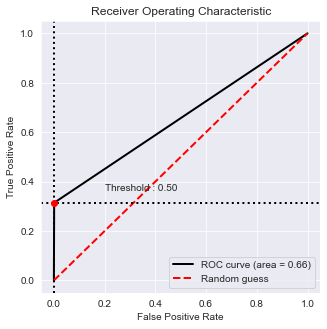

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

TRAIN_DATASET_PATH = './data/assignment_2_train.csv'
train = pd.read_csv(TRAIN_DATASET_PATH)

numerical_features = train.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32']).columns

data = train[numerical_features]
target = train['isFraud']

x_train, x_valid = train_test_split(data, train_size=0.8, random_state=1)
y_train, y_valid = train_test_split(target, train_size=0.8, random_state=1)

params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

model = xgb.XGBClassifier(**params)
model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=10
)
# make predictions for test data
y_pred = model.predict(x_valid)
preds = [round(value) for value in y_pred]
y_test = list(y_valid)

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

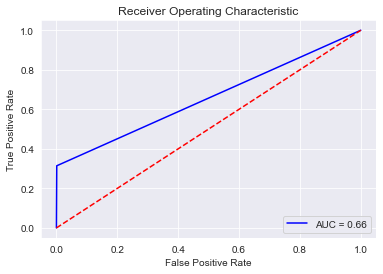

In [117]:
#XGBoost plot Roc кривая
from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')
    
buildROC(y_test, y_pred)

### LightGBM plot Roc кривая

Training until validation scores don't improve for 25 rounds
[10]	training's auc: 0.833851	valid_1's auc: 0.83047
[20]	training's auc: 0.83805	valid_1's auc: 0.833559
[30]	training's auc: 0.865735	valid_1's auc: 0.860417
[40]	training's auc: 0.873545	valid_1's auc: 0.867133
[50]	training's auc: 0.878139	valid_1's auc: 0.869278
[60]	training's auc: 0.881281	valid_1's auc: 0.872269
[70]	training's auc: 0.88287	valid_1's auc: 0.874168
[80]	training's auc: 0.884983	valid_1's auc: 0.875948
[90]	training's auc: 0.886449	valid_1's auc: 0.876993
[100]	training's auc: 0.888211	valid_1's auc: 0.87777
[110]	training's auc: 0.889141	valid_1's auc: 0.879241
[120]	training's auc: 0.891341	valid_1's auc: 0.88049
[130]	training's auc: 0.892671	valid_1's auc: 0.881388
[140]	training's auc: 0.893938	valid_1's auc: 0.882437
[150]	training's auc: 0.895089	valid_1's auc: 0.883594
[160]	training's auc: 0.896685	valid_1's auc: 0.884503
[170]	training's auc: 0.898	valid_1's auc: 0.885442
[180]	training's auc:

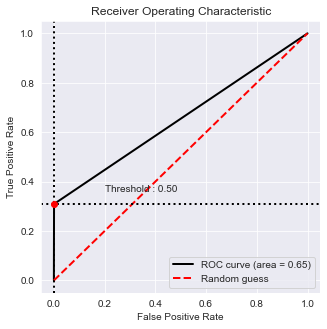

In [118]:
params = {
    "boosting_type": "gbdt",  # gradient boosting tree decision tree
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 200,  # число деревьев
    "n_jobs": 6,
    "seed": 27
}

model = lgb.LGBMClassifier(**params)
y = model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    early_stopping_rounds=25,
    eval_metric="auc",
    verbose=10
)

# make predictions for test data
y_pred = model.predict(x_valid)
preds = [round(value) for value in y_pred]
y_test = list(y_valid)

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

### CatBoost plot Roc кривая

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7615702	test1: 0.7487818	best: 0.7487818 (0)	total: 271ms	remaining: 4m 31s
10:	test: 0.8199551	test1: 0.8109260	best: 0.8109260 (10)	total: 1.61s	remaining: 2m 25s
20:	test: 0.8247723	test1: 0.8111688	best: 0.8132692 (13)	total: 2.49s	remaining: 1m 56s
30:	test: 0.8412945	test1: 0.8324845	best: 0.8325651 (29)	total: 3.35s	remaining: 1m 44s
40:	test: 0.8457663	test1: 0.8371246	best: 0.8371246 (40)	total: 4.34s	remaining: 1m 41s
50:	test: 0.8486648	test1: 0.8402671	best: 0.8402671 (50)	total: 5.16s	remaining: 1m 35s
60:	test: 0.8521082	test1: 0.8454715	best: 0.8454715 (60)	total: 5.89s	remaining: 1m 30s
70:	test: 0.8530905	test1: 0.8476468	best: 0.8477893 (66)	total: 6.62s	remaining: 1m 26s
80:	test: 0.8569671	test1: 0.8503087	best: 0.8505791 (77)	total: 7.35s	remaining: 1m 23s
90:	test: 0.8585353	test1: 0.8515643	best: 0.8517219 (85)	total: 8.16s	remaining: 1m 21s
100:	test: 0.8586887	test1: 0.8519240	best: 0.8519240 (100)	total: 8.92s	remaining: 1m 19s
110:	test: 0.8590225	

920:	test: 0.8864293	test1: 0.8797988	best: 0.8798000 (915)	total: 1m 28s	remaining: 7.63s
930:	test: 0.8864308	test1: 0.8798193	best: 0.8798193 (930)	total: 1m 30s	remaining: 6.7s
940:	test: 0.8865382	test1: 0.8798970	best: 0.8798970 (940)	total: 1m 31s	remaining: 5.76s
950:	test: 0.8865720	test1: 0.8799345	best: 0.8799345 (950)	total: 1m 33s	remaining: 4.82s
960:	test: 0.8867638	test1: 0.8800468	best: 0.8800468 (960)	total: 1m 34s	remaining: 3.85s
970:	test: 0.8869668	test1: 0.8802774	best: 0.8802774 (970)	total: 1m 35s	remaining: 2.87s
980:	test: 0.8872719	test1: 0.8806114	best: 0.8806114 (980)	total: 1m 36s	remaining: 1.88s
990:	test: 0.8875976	test1: 0.8809324	best: 0.8809324 (990)	total: 1m 37s	remaining: 888ms
999:	test: 0.8879360	test1: 0.8812724	best: 0.8812724 (999)	total: 1m 38s	remaining: 0us

bestTest = 0.8812724143
bestIteration = 999



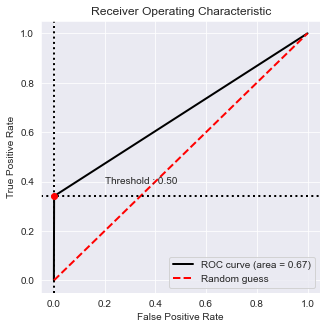

In [119]:
cb_params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,  # Как часто выводим на экран статистику
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)
model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    plot=True
)

# make predictions for test data
y_pred = model.predict(x_valid)
preds = [round(value) for value in y_pred]
y_test = list(y_valid)

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

**Задание на повторение:**

Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных, этот набор данных будет использован и для следующего домашнего задания.

**[Задание 1](#task_1):** Построить график распределения времени совершения транзакции ("TransactionDT") для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

<AxesSubplot:>

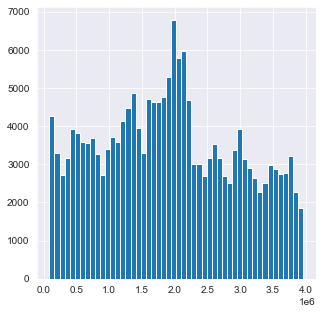

In [123]:
df_num_features = train['TransactionDT']
df_num_features.hist(figsize=(5, 5), bins=50, grid=True)
# для более подробного анализа графиков, можно выводить гистограммы для небольших груп признаков

**[Задание 2](#task_2):** построить scatter-plot зависимости суммы транзакции ("TransactionAmt"?) от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

In [139]:
#scatter plot lib example using matplotlbimport numpy as np
import matplotlib.pyplot as plt# Create data
#N = 100
x = train['TransactionAmt']
y = train['TransactionDT']
print(train['TransactionAmt'].isna().sum())
print(train['TransactionDT'].isna().sum())
print(x.head(2))
print(y.head(2))
x = list(x)
y = list(y)
print(len(x))
print(len(y))


colors = (0, 100, 255)
area = np.pi*3  # Plot


0
0
0    68.5
1    29.0
Name: TransactionAmt, dtype: float64
0    86400
1    86401
Name: TransactionDT, dtype: int64
180000
180000


In [1]:
"""
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title('Scatter plot example using matplotlib')
plt.xlabel('x')
plt.ylabel('y')

plt.show()"""

"\nplt.scatter(x, y, s=area, c=colors, alpha=0.5)\nplt.title('Scatter plot example using matplotlib')\nplt.xlabel('x')\nplt.ylabel('y')\n\nplt.show()"

**[Задание 3](#task_3):** построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

**[Задание 4](#task_4):** построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.